##### Copyright 2019 The TensorFlow Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Image segmentation

This tutorial focuses on the task of image segmentation, using a modified <a href="https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/" class="external">U-Net</a>.

## What is image segmentation?

In an image classification task, the network assigns a label (or class) to each input image. However, suppose you want to know the shape of that object, which pixel belongs to which object, etc. In this case, you need to assign a class to each pixel of the image—this task is known as segmentation. A segmentation model returns much more detailed information about the image. Image segmentation has many applications in medical imaging, self-driving cars and satellite imaging, just to name a few.

This tutorial uses the [Oxford-IIIT Pet Dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/) ([Parkhi et al, 2012](https://www.robots.ox.ac.uk/~vgg/publications/2012/parkhi12a/parkhi12a.pdf)). The dataset consists of images of 37 pet breeds, with 200 images per breed (~100 each in the training and test splits). Each image includes the corresponding labels, and pixel-wise masks. The masks are class-labels for each pixel. Each pixel is given one of three categories:

- Class 1: Pixel belonging to the pet.
- Class 2: Pixel bordering the pet.
- Class 3: None of the above/a surrounding pixel.

In [1]:
import numpy as np

import tensorflow as tf
import tensorflow_datasets as tfds

2024-05-08 19:58:05.036293: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-08 19:58:05.036319: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-08 19:58:05.036933: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-08 19:58:05.040533: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
from tensorflow_examples.models.pix2pix import pix2pix

from IPython.display import clear_output
import matplotlib.pyplot as plt

## Download the Oxford-IIIT Pets dataset

The dataset is [available from TensorFlow Datasets](https://www.tensorflow.org/datasets/catalog/oxford_iiit_pet). The segmentation masks are included in version 3+.

In [3]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

2024-05-08 19:58:14.747837: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-08 19:58:14.751920: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-08 19:58:14.752016: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

 In addition, the image color values are normalized to the `[0, 1]` range. Finally, as mentioned above the pixels in the segmentation mask are labeled either {1, 2, 3}. For the sake of convenience, subtract 1 from the segmentation mask, resulting in labels that are : {0, 1, 2}.

In [4]:
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask

In [5]:
def load_image(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(
    datapoint['segmentation_mask'],
    (128, 128),
    method = tf.image.ResizeMethod.NEAREST_NEIGHBOR,
  )

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

The dataset already contains the required training and test splits, so continue to use the same splits:

In [6]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [7]:
train_images = dataset['train'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
test_images = dataset['test'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

The following class performs a simple augmentation by randomly-flipping an image.
Go to the [Image augmentation](data_augmentation.ipynb) tutorial to learn more.


In [8]:
class Augment(tf.keras.layers.Layer):
  def __init__(self, seed=42):
    super().__init__()
    # both use the same seed, so they'll make the same random changes.
    self.augment_inputs = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)
    self.augment_labels = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)

  def call(self, inputs, labels):
    inputs = self.augment_inputs(inputs)
    labels = self.augment_labels(labels)
    return inputs, labels

Build the input pipeline, applying the augmentation after batching the inputs:

In [9]:
train_batches = (
    train_images
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
    .map(Augment())
    .prefetch(buffer_size=tf.data.AUTOTUNE))

test_batches = test_images.batch(BATCH_SIZE)

Visualize an image example and its corresponding mask from the dataset:

In [10]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


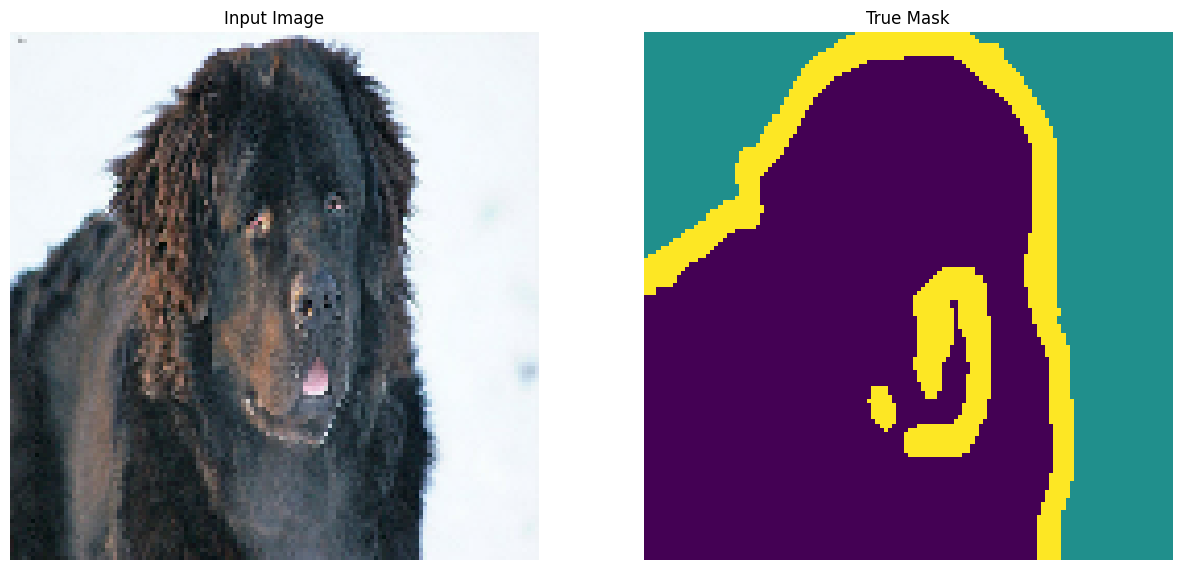

2024-05-08 19:58:41.823060: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


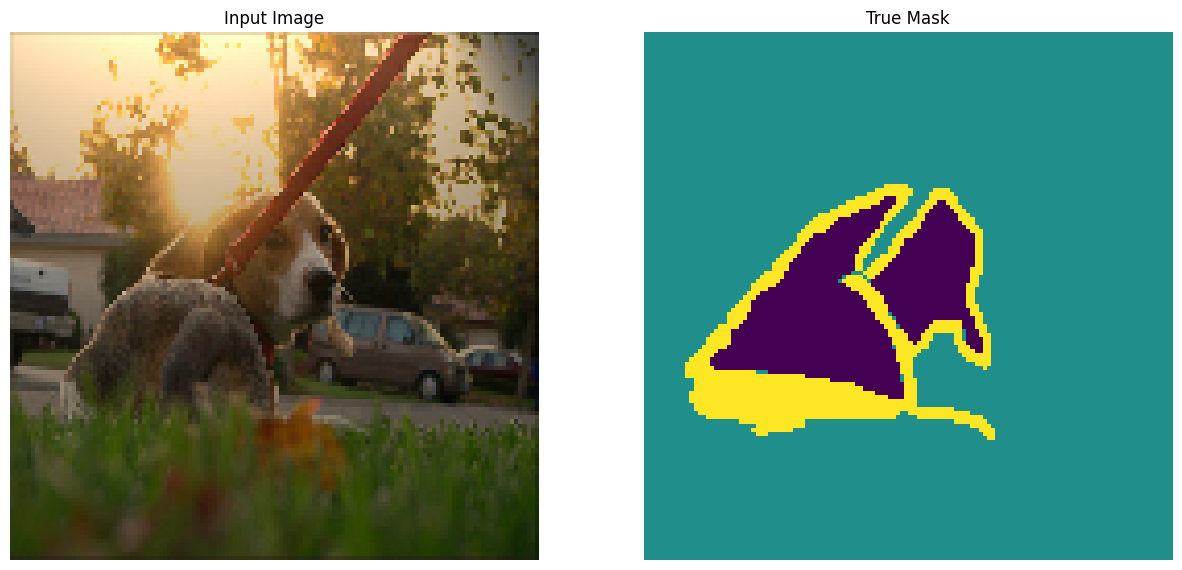

In [11]:
for images, masks in train_batches.take(2):
  sample_image, sample_mask = images[0], masks[0]
  display([sample_image, sample_mask])

## Define the model
The model being used here is a modified [U-Net](https://arxiv.org/abs/1505.04597). A U-Net consists of an encoder (downsampler) and decoder (upsampler). To learn robust features and reduce the number of trainable parameters, use a pretrained model—[MobileNetV2](https://arxiv.org/abs/1801.04381)—as the encoder. For the decoder, you will use the upsample block, which is already implemented in the [pix2pix](https://github.com/tensorflow/examples/blob/master/tensorflow_examples/models/pix2pix/pix2pix.py) example in the TensorFlow Examples repo. (Check out the [pix2pix: Image-to-image translation with a conditional GAN](../generative/pix2pix.ipynb) tutorial in a notebook.)


As mentioned, the encoder is a pretrained MobileNetV2 model. You will use the model from `tf.keras.applications`. The encoder consists of specific outputs from intermediate layers in the model. Note that the encoder will not be trained during the training process.

In [12]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


The decoder/upsampler is simply a series of upsample blocks implemented in TensorFlow examples:

In [13]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [14]:
def unet_model(output_channels:int):
  inputs = tf.keras.layers.Input(shape=[128, 128, 3])

  # Downsampling through the model
  skips = down_stack(inputs)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      filters=output_channels, kernel_size=3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

Note that the number of filters on the last layer is set to the number of `output_channels`. This will be one output channel per class.

## Train the model

Now, all that is left to do is to compile and train the model.

Since this is a multiclass classification problem, use the `tf.keras.losses.SparseCategoricalCrossentropy` loss function with the `from_logits` argument set to `True`, since the labels are scalar integers instead of vectors of scores for each pixel of every class.

When running inference, the label assigned to the pixel is the channel with the highest value. This is what the `create_mask` function is doing.

In [15]:
OUTPUT_CLASSES = 3

model = unet_model(output_channels=OUTPUT_CLASSES)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Plot the resulting model architecture:

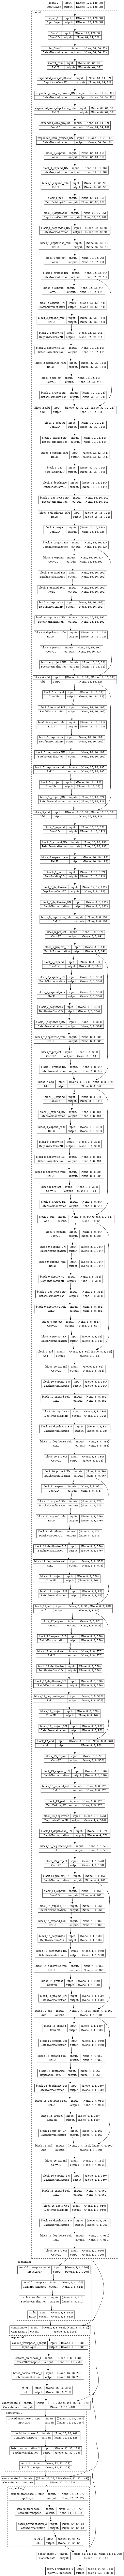

In [16]:
tf.keras.utils.plot_model(model, show_shapes=True, expand_nested=True, dpi=64)

Try out the model to check what it predicts before training:

In [17]:
def create_mask(pred_mask):
  pred_mask = tf.math.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [18]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

2024-05-08 20:10:29.286774: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8906


1/1 [==============================] - 2s 2s/step


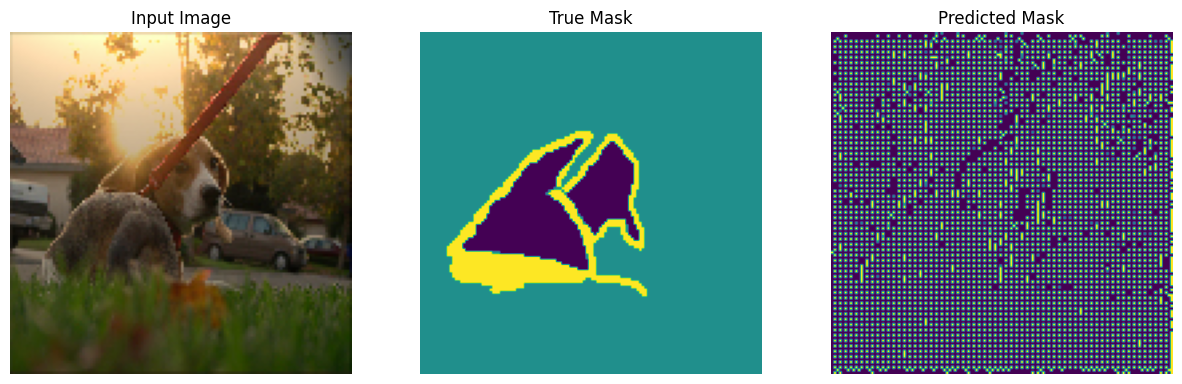

In [19]:
show_predictions()

The callback defined below is used to observe how the model improves while it is training:

In [20]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

1/1 [==============================] - 0s 12ms/step


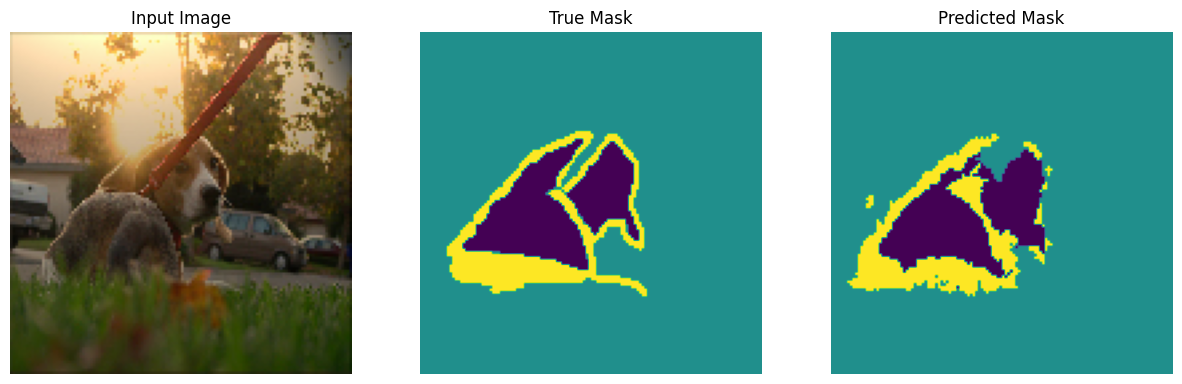


Sample Prediction after epoch 20

57/57 [==============================] - 2s 32ms/step - loss: 0.1720 - accuracy: 0.9299 - val_loss: 0.2646 - val_accuracy: 0.9070


In [21]:
EPOCHS = 20
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_batches, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_batches,
                          callbacks=[DisplayCallback()])

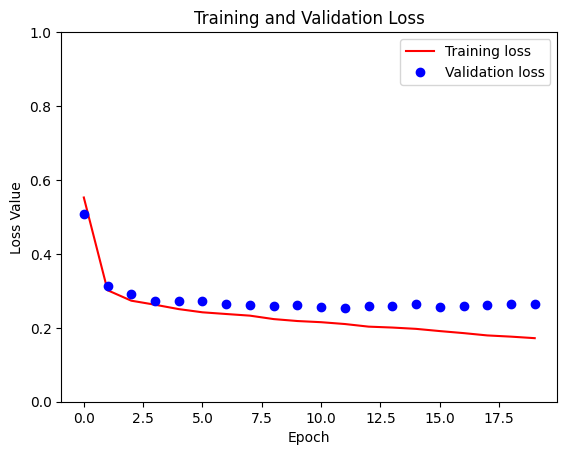

In [22]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.figure()
plt.plot(model_history.epoch, loss, 'r', label='Training loss')
plt.plot(model_history.epoch, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

## Make predictions

Now, make some predictions. In the interest of saving time, the number of epochs was kept small, but you may set this higher to achieve more accurate results.

2/2 [==============================] - 0s 8ms/step


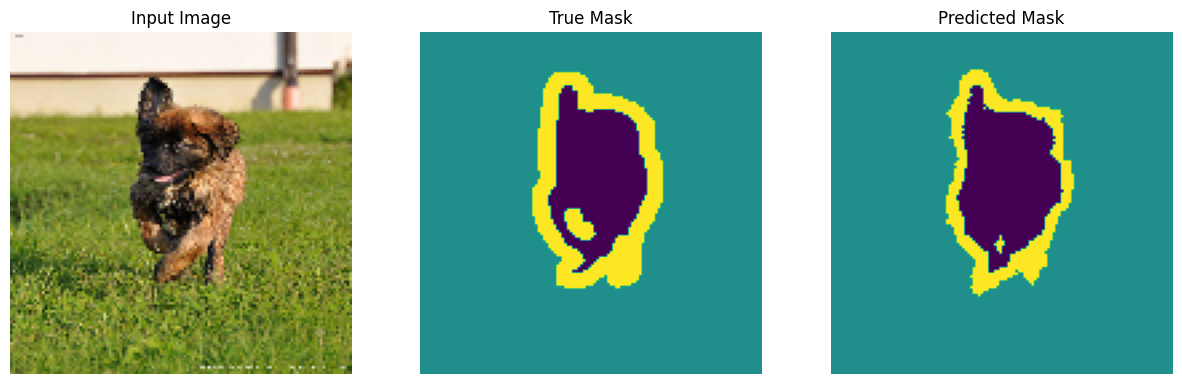

2/2 [==============================] - 0s 7ms/step


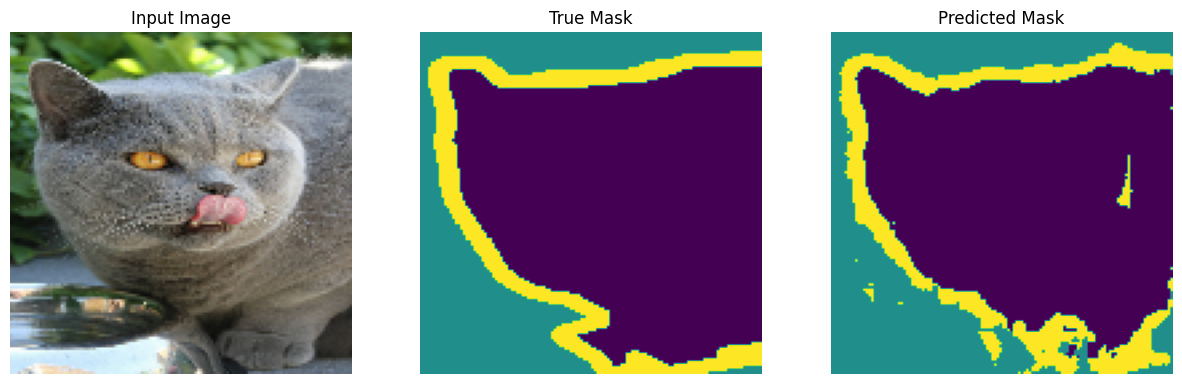

2/2 [==============================] - 0s 8ms/step


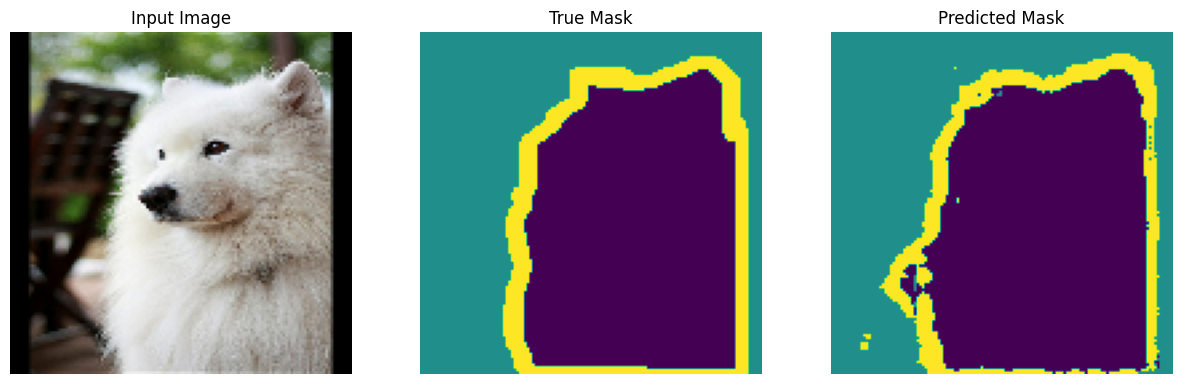

In [23]:
show_predictions(test_batches, 3)

## Optional: Imbalanced classes and class weights

Semantic segmentation datasets can be highly imbalanced meaning that particular class pixels can be present more inside images than that of other classes. Since segmentation problems can be treated as per-pixel classification problems, you can deal with the imbalance problem by weighing the loss function to account for this. It's a simple and elegant way to deal with this problem. Refer to the [Classification on imbalanced data](../structured_data/imbalanced_data.ipynb) tutorial to learn more.

To [avoid ambiguity](https://github.com/keras-team/keras/issues/3653#issuecomment-243939748), `Model.fit` does not support the `class_weight` argument for targets with 3+ dimensions.

In [24]:
try:
  model_history = model.fit(train_batches, epochs=EPOCHS,
                            steps_per_epoch=STEPS_PER_EPOCH,
                            class_weight = {0:2.0, 1:2.0, 2:1.0})
  assert False
except Exception as e:
  print(f"Expected {type(e).__name__}: {e}")

Epoch 1/20
57/57 [==============================] - 2s 27ms/step - loss: 0.2577 - accuracy: 0.9219
Epoch 2/20
57/57 [==============================] - 2s 27ms/step - loss: 0.2504 - accuracy: 0.9239
Epoch 3/20
57/57 [==============================] - 2s 27ms/step - loss: 0.2390 - accuracy: 0.9266
Epoch 4/20
57/57 [==============================] - 2s 27ms/step - loss: 0.2295 - accuracy: 0.9291
Epoch 5/20
57/57 [==============================] - 2s 27ms/step - loss: 0.2205 - accuracy: 0.9313
Epoch 6/20
57/57 [==============================] - 2s 27ms/step - loss: 0.2161 - accuracy: 0.9325
Epoch 7/20
57/57 [==============================] - 2s 27ms/step - loss: 0.2052 - accuracy: 0.9352
Epoch 8/20
57/57 [==============================] - 2s 27ms/step - loss: 0.2038 - accuracy: 0.9357
Epoch 9/20
57/57 [==============================] - 2s 27ms/step - loss: 0.1936 - accuracy: 0.9384
Epoch 10/20
57/57 [==============================] - 2s 27ms/step - loss: 0.1912 - accuracy: 0.9393
Epoch 11/

 7/57 ━━━━━━━━━━━━━━━━━━━━ 5s 102ms/step - accuracy: 0.9296 - loss: 0.2406

 8/57 ━━━━━━━━━━━━━━━━━━━━ 4s 101ms/step - accuracy: 0.9293 - loss: 0.2406

 9/57 ━━━━━━━━━━━━━━━━━━━━ 4s 100ms/step - accuracy: 0.9290 - loss: 0.2408

10/57 ━━━━━━━━━━━━━━━━━━━━ 4s 100ms/step - accuracy: 0.9288 - loss: 0.2408

11/57 ━━━━━━━━━━━━━━━━━━━━ 4s 99ms/step - accuracy: 0.9286 - loss: 0.2408 

12/57 ━━━━━━━━━━━━━━━━━━━━ 4s 99ms/step - accuracy: 0.9284 - loss: 0.2408

13/57 ━━━━━━━━━━━━━━━━━━━━ 4s 98ms/step - accuracy: 0.9282 - loss: 0.2410

14/57 ━━━━━━━━━━━━━━━━━━━━ 4s 98ms/step - accuracy: 0.9281 - loss: 0.2412

15/57 ━━━━━━━━━━━━━━━━━━━━ 4s 98ms/step - accuracy: 0.9279 - loss: 0.2413

16/57 ━━━━━━━━━━━━━━━━━━━━ 4s 98ms/step - accuracy: 0.9278 - loss: 0.2414

17/57 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step - accuracy: 0.9277 - loss: 0.2415

18/57 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step - accuracy: 0.9276 - loss: 0.2417

19/57 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - accuracy: 0.9275 - loss: 0.2419

20/57 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - accuracy: 0.9274 - loss: 0.2421

21/57 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - accuracy: 0.9273 - loss: 0.2423

22/57 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - accuracy: 0.9272 - loss: 0.2425

23/57 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - accuracy: 0.9271 - loss: 0.2427

24/57 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - accuracy: 0.9270 - loss: 0.2429

25/57 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - accuracy: 0.9269 - loss: 0.2431

26/57 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - accuracy: 0.9268 - loss: 0.2433

27/57 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - accuracy: 0.9267 - loss: 0.2436

28/57 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - accuracy: 0.9266 - loss: 0.2438

29/57 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - accuracy: 0.9265 - loss: 0.2441

30/57 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - accuracy: 0.9264 - loss: 0.2443

31/57 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - accuracy: 0.9263 - loss: 0.2446

32/57 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - accuracy: 0.9263 - loss: 0.2449

33/57 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - accuracy: 0.9262 - loss: 0.2451

34/57 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - accuracy: 0.9261 - loss: 0.2453

35/57 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - accuracy: 0.9260 - loss: 0.2455

36/57 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - accuracy: 0.9260 - loss: 0.2457

37/57 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - accuracy: 0.9259 - loss: 0.2459

38/57 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - accuracy: 0.9258 - loss: 0.2461

39/57 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - accuracy: 0.9258 - loss: 0.2463

40/57 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - accuracy: 0.9257 - loss: 0.2465

41/57 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - accuracy: 0.9257 - loss: 0.2467

42/57 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - accuracy: 0.9256 - loss: 0.2469

43/57 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - accuracy: 0.9255 - loss: 0.2471

44/57 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - accuracy: 0.9255 - loss: 0.2472

45/57 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - accuracy: 0.9254 - loss: 0.2474

46/57 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - accuracy: 0.9254 - loss: 0.2476

47/57 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.9253 - loss: 0.2477

48/57 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.9253 - loss: 0.2479

49/57 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.9252 - loss: 0.2480

50/57 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.9252 - loss: 0.2481

51/57 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.9252 - loss: 0.2483

52/57 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.9251 - loss: 0.2484

53/57 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.9251 - loss: 0.2486

54/57 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.9250 - loss: 0.2487

55/57 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.9250 - loss: 0.2489

56/57 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.9249 - loss: 0.2490

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.9249 - loss: 0.2492

57/57 ━━━━━━━━━━━━━━━━━━━━ 12s 96ms/step - accuracy: 0.9248 - loss: 0.2493


Epoch 2/20


W0000 00:00:1712971478.676844   10582 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


 1/57 ━━━━━━━━━━━━━━━━━━━━ 2:40 3s/step - accuracy: 0.9205 - loss: 0.2641

 2/57 ━━━━━━━━━━━━━━━━━━━━ 7s 144ms/step - accuracy: 0.9193 - loss: 0.2664

 3/57 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 0.9182 - loss: 0.2697

 4/57 ━━━━━━━━━━━━━━━━━━━━ 6s 116ms/step - accuracy: 0.9181 - loss: 0.2686

 5/57 ━━━━━━━━━━━━━━━━━━━━ 5s 111ms/step - accuracy: 0.9182 - loss: 0.2675

 6/57 ━━━━━━━━━━━━━━━━━━━━ 5s 107ms/step - accuracy: 0.9183 - loss: 0.2674

 7/57 ━━━━━━━━━━━━━━━━━━━━ 5s 105ms/step - accuracy: 0.9184 - loss: 0.2675

 8/57 ━━━━━━━━━━━━━━━━━━━━ 5s 104ms/step - accuracy: 0.9185 - loss: 0.2676

 9/57 ━━━━━━━━━━━━━━━━━━━━ 4s 103ms/step - accuracy: 0.9186 - loss: 0.2674

10/57 ━━━━━━━━━━━━━━━━━━━━ 4s 102ms/step - accuracy: 0.9186 - loss: 0.2672

11/57 ━━━━━━━━━━━━━━━━━━━━ 4s 101ms/step - accuracy: 0.9187 - loss: 0.2670

12/57 ━━━━━━━━━━━━━━━━━━━━ 4s 101ms/step - accuracy: 0.9187 - loss: 0.2671

13/57 ━━━━━━━━━━━━━━━━━━━━ 4s 100ms/step - accuracy: 0.9188 - loss: 0.2671

14/57 ━━━━━━━━━━━━━━━━━━━━ 4s 100ms/step - accuracy: 0.9188 - loss: 0.2672

15/57 ━━━━━━━━━━━━━━━━━━━━ 4s 100ms/step - accuracy: 0.9189 - loss: 0.2671

16/57 ━━━━━━━━━━━━━━━━━━━━ 4s 99ms/step - accuracy: 0.9189 - loss: 0.2670 

17/57 ━━━━━━━━━━━━━━━━━━━━ 3s 99ms/step - accuracy: 0.9190 - loss: 0.2668

18/57 ━━━━━━━━━━━━━━━━━━━━ 3s 99ms/step - accuracy: 0.9190 - loss: 0.2666

19/57 ━━━━━━━━━━━━━━━━━━━━ 3s 99ms/step - accuracy: 0.9191 - loss: 0.2664

20/57 ━━━━━━━━━━━━━━━━━━━━ 3s 99ms/step - accuracy: 0.9192 - loss: 0.2661

21/57 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step - accuracy: 0.9193 - loss: 0.2658

22/57 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step - accuracy: 0.9194 - loss: 0.2655

23/57 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step - accuracy: 0.9195 - loss: 0.2652

24/57 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step - accuracy: 0.9196 - loss: 0.2649

25/57 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step - accuracy: 0.9196 - loss: 0.2647

26/57 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step - accuracy: 0.9197 - loss: 0.2644

27/57 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - accuracy: 0.9198 - loss: 0.2642

28/57 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - accuracy: 0.9198 - loss: 0.2641

29/57 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - accuracy: 0.9199 - loss: 0.2639

30/57 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - accuracy: 0.9200 - loss: 0.2637

31/57 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - accuracy: 0.9200 - loss: 0.2635

32/57 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - accuracy: 0.9201 - loss: 0.2634

33/57 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - accuracy: 0.9201 - loss: 0.2632

34/57 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - accuracy: 0.9202 - loss: 0.2631

35/57 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - accuracy: 0.9202 - loss: 0.2630

36/57 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - accuracy: 0.9203 - loss: 0.2628

37/57 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - accuracy: 0.9203 - loss: 0.2627

38/57 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - accuracy: 0.9204 - loss: 0.2626

39/57 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - accuracy: 0.9204 - loss: 0.2625

40/57 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - accuracy: 0.9205 - loss: 0.2624

41/57 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - accuracy: 0.9205 - loss: 0.2623

42/57 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - accuracy: 0.9205 - loss: 0.2623

43/57 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - accuracy: 0.9205 - loss: 0.2622

44/57 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - accuracy: 0.9206 - loss: 0.2622

45/57 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - accuracy: 0.9206 - loss: 0.2621

46/57 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - accuracy: 0.9206 - loss: 0.2621

47/57 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.9206 - loss: 0.2621

48/57 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.9206 - loss: 0.2620

49/57 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.9206 - loss: 0.2620

50/57 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.9207 - loss: 0.2619

51/57 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.9207 - loss: 0.2619

52/57 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.9207 - loss: 0.2619

53/57 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.9207 - loss: 0.2618

54/57 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.9207 - loss: 0.2618

55/57 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.9207 - loss: 0.2618

56/57 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.9207 - loss: 0.2617

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.9208 - loss: 0.2617

57/57 ━━━━━━━━━━━━━━━━━━━━ 8s 97ms/step - accuracy: 0.9208 - loss: 0.2617


Epoch 3/20


 1/57 ━━━━━━━━━━━━━━━━━━━━ 5s 92ms/step - accuracy: 0.9271 - loss: 0.2406

 2/57 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - accuracy: 0.9275 - loss: 0.2395

 3/57 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step - accuracy: 0.9268 - loss: 0.2427

 4/57 ━━━━━━━━━━━━━━━━━━━━ 4s 81ms/step - accuracy: 0.9267 - loss: 0.2431

 5/57 ━━━━━━━━━━━━━━━━━━━━ 4s 84ms/step - accuracy: 0.9264 - loss: 0.2440

 6/57 ━━━━━━━━━━━━━━━━━━━━ 4s 87ms/step - accuracy: 0.9261 - loss: 0.2446

 7/57 ━━━━━━━━━━━━━━━━━━━━ 4s 88ms/step - accuracy: 0.9258 - loss: 0.2455

 8/57 ━━━━━━━━━━━━━━━━━━━━ 4s 89ms/step - accuracy: 0.9256 - loss: 0.2462

 9/57 ━━━━━━━━━━━━━━━━━━━━ 4s 90ms/step - accuracy: 0.9254 - loss: 0.2466

10/57 ━━━━━━━━━━━━━━━━━━━━ 4s 91ms/step - accuracy: 0.9254 - loss: 0.2467

11/57 ━━━━━━━━━━━━━━━━━━━━ 4s 92ms/step - accuracy: 0.9253 - loss: 0.2468

12/57 ━━━━━━━━━━━━━━━━━━━━ 4s 92ms/step - accuracy: 0.9253 - loss: 0.2469

13/57 ━━━━━━━━━━━━━━━━━━━━ 4s 92ms/step - accuracy: 0.9253 - loss: 0.2468

14/57 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - accuracy: 0.9253 - loss: 0.2468

15/57 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - accuracy: 0.9253 - loss: 0.2467

16/57 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - accuracy: 0.9252 - loss: 0.2467

17/57 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - accuracy: 0.9252 - loss: 0.2467

18/57 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - accuracy: 0.9252 - loss: 0.2466

19/57 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - accuracy: 0.9252 - loss: 0.2466

20/57 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - accuracy: 0.9252 - loss: 0.2466

21/57 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - accuracy: 0.9251 - loss: 0.2467

22/57 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - accuracy: 0.9251 - loss: 0.2467

23/57 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - accuracy: 0.9251 - loss: 0.2468

24/57 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - accuracy: 0.9250 - loss: 0.2468

25/57 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - accuracy: 0.9250 - loss: 0.2469

26/57 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - accuracy: 0.9250 - loss: 0.2469

27/57 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - accuracy: 0.9250 - loss: 0.2469

28/57 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - accuracy: 0.9250 - loss: 0.2470

29/57 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - accuracy: 0.9249 - loss: 0.2470

30/57 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - accuracy: 0.9249 - loss: 0.2470

31/57 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - accuracy: 0.9249 - loss: 0.2470

32/57 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - accuracy: 0.9249 - loss: 0.2470

33/57 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - accuracy: 0.9249 - loss: 0.2469

34/57 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - accuracy: 0.9249 - loss: 0.2469

35/57 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - accuracy: 0.9249 - loss: 0.2469

36/57 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - accuracy: 0.9249 - loss: 0.2469

37/57 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - accuracy: 0.9249 - loss: 0.2469

38/57 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - accuracy: 0.9249 - loss: 0.2469

39/57 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - accuracy: 0.9249 - loss: 0.2469

40/57 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - accuracy: 0.9249 - loss: 0.2468

41/57 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - accuracy: 0.9249 - loss: 0.2468

42/57 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - accuracy: 0.9249 - loss: 0.2468

43/57 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - accuracy: 0.9249 - loss: 0.2468

44/57 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - accuracy: 0.9249 - loss: 0.2468

45/57 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - accuracy: 0.9249 - loss: 0.2468

46/57 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - accuracy: 0.9249 - loss: 0.2467

47/57 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.9249 - loss: 0.2467

48/57 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.9249 - loss: 0.2467

49/57 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.9249 - loss: 0.2467

50/57 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.9249 - loss: 0.2466

51/57 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.9249 - loss: 0.2466

52/57 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.9249 - loss: 0.2466

53/57 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.9249 - loss: 0.2466

54/57 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.9249 - loss: 0.2465

55/57 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.9249 - loss: 0.2465

56/57 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.9249 - loss: 0.2464

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.9250 - loss: 0.2464

57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 97ms/step - accuracy: 0.9250 - loss: 0.2464


Epoch 4/20


 1/57 ━━━━━━━━━━━━━━━━━━━━ 5s 95ms/step - accuracy: 0.9206 - loss: 0.2615

 2/57 ━━━━━━━━━━━━━━━━━━━━ 5s 100ms/step - accuracy: 0.9215 - loss: 0.2584

 3/57 ━━━━━━━━━━━━━━━━━━━━ 4s 78ms/step - accuracy: 0.9220 - loss: 0.2567 

 4/57 ━━━━━━━━━━━━━━━━━━━━ 4s 84ms/step - accuracy: 0.9227 - loss: 0.2538

 5/57 ━━━━━━━━━━━━━━━━━━━━ 4s 87ms/step - accuracy: 0.9233 - loss: 0.2516

 6/57 ━━━━━━━━━━━━━━━━━━━━ 4s 89ms/step - accuracy: 0.9236 - loss: 0.2500

 7/57 ━━━━━━━━━━━━━━━━━━━━ 4s 91ms/step - accuracy: 0.9239 - loss: 0.2486

 8/57 ━━━━━━━━━━━━━━━━━━━━ 4s 92ms/step - accuracy: 0.9241 - loss: 0.2475

 9/57 ━━━━━━━━━━━━━━━━━━━━ 4s 93ms/step - accuracy: 0.9244 - loss: 0.2465

10/57 ━━━━━━━━━━━━━━━━━━━━ 4s 93ms/step - accuracy: 0.9246 - loss: 0.2456

11/57 ━━━━━━━━━━━━━━━━━━━━ 4s 93ms/step - accuracy: 0.9248 - loss: 0.2447

12/57 ━━━━━━━━━━━━━━━━━━━━ 4s 94ms/step - accuracy: 0.9250 - loss: 0.2438

13/57 ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/step - accuracy: 0.9251 - loss: 0.2432

14/57 ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/step - accuracy: 0.9253 - loss: 0.2427

15/57 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - accuracy: 0.9254 - loss: 0.2421

16/57 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - accuracy: 0.9256 - loss: 0.2416

17/57 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - accuracy: 0.9258 - loss: 0.2410

18/57 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - accuracy: 0.9259 - loss: 0.2405

19/57 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - accuracy: 0.9260 - loss: 0.2401

20/57 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - accuracy: 0.9261 - loss: 0.2397

21/57 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - accuracy: 0.9262 - loss: 0.2394

22/57 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - accuracy: 0.9263 - loss: 0.2391

23/57 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - accuracy: 0.9264 - loss: 0.2389

24/57 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - accuracy: 0.9264 - loss: 0.2387

25/57 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - accuracy: 0.9265 - loss: 0.2385

26/57 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - accuracy: 0.9265 - loss: 0.2383

27/57 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - accuracy: 0.9266 - loss: 0.2381

28/57 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - accuracy: 0.9266 - loss: 0.2380

29/57 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - accuracy: 0.9267 - loss: 0.2378

30/57 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - accuracy: 0.9267 - loss: 0.2376

31/57 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - accuracy: 0.9268 - loss: 0.2375

32/57 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - accuracy: 0.9268 - loss: 0.2373

33/57 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - accuracy: 0.9269 - loss: 0.2372

34/57 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - accuracy: 0.9269 - loss: 0.2371

35/57 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - accuracy: 0.9269 - loss: 0.2370

36/57 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - accuracy: 0.9270 - loss: 0.2368

37/57 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - accuracy: 0.9270 - loss: 0.2367

38/57 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - accuracy: 0.9270 - loss: 0.2366

39/57 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - accuracy: 0.9271 - loss: 0.2365

40/57 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - accuracy: 0.9271 - loss: 0.2364

41/57 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - accuracy: 0.9271 - loss: 0.2363

42/57 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - accuracy: 0.9272 - loss: 0.2362

43/57 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - accuracy: 0.9272 - loss: 0.2361

44/57 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - accuracy: 0.9272 - loss: 0.2360

45/57 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - accuracy: 0.9273 - loss: 0.2359

46/57 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - accuracy: 0.9273 - loss: 0.2358

47/57 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.9273 - loss: 0.2357

48/57 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.9273 - loss: 0.2356

49/57 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.9274 - loss: 0.2355

50/57 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.9274 - loss: 0.2355

51/57 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.9274 - loss: 0.2354

52/57 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.9274 - loss: 0.2353

53/57 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.9274 - loss: 0.2353

54/57 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.9274 - loss: 0.2352

55/57 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.9275 - loss: 0.2352

56/57 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.9275 - loss: 0.2351

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.9275 - loss: 0.2351

57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.9275 - loss: 0.2350


Epoch 5/20


 1/57 ━━━━━━━━━━━━━━━━━━━━ 5s 96ms/step - accuracy: 0.9267 - loss: 0.2371

 2/57 ━━━━━━━━━━━━━━━━━━━━ 5s 100ms/step - accuracy: 0.9266 - loss: 0.2369

 3/57 ━━━━━━━━━━━━━━━━━━━━ 5s 100ms/step - accuracy: 0.9274 - loss: 0.2341

 4/57 ━━━━━━━━━━━━━━━━━━━━ 4s 86ms/step - accuracy: 0.9277 - loss: 0.2332 

 5/57 ━━━━━━━━━━━━━━━━━━━━ 4s 88ms/step - accuracy: 0.9281 - loss: 0.2320

 6/57 ━━━━━━━━━━━━━━━━━━━━ 4s 90ms/step - accuracy: 0.9282 - loss: 0.2312

 7/57 ━━━━━━━━━━━━━━━━━━━━ 4s 91ms/step - accuracy: 0.9283 - loss: 0.2307

 8/57 ━━━━━━━━━━━━━━━━━━━━ 4s 93ms/step - accuracy: 0.9284 - loss: 0.2305

 9/57 ━━━━━━━━━━━━━━━━━━━━ 4s 93ms/step - accuracy: 0.9285 - loss: 0.2302

10/57 ━━━━━━━━━━━━━━━━━━━━ 4s 94ms/step - accuracy: 0.9285 - loss: 0.2301

11/57 ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/step - accuracy: 0.9286 - loss: 0.2298

12/57 ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/step - accuracy: 0.9288 - loss: 0.2295

13/57 ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/step - accuracy: 0.9289 - loss: 0.2291

14/57 ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/step - accuracy: 0.9290 - loss: 0.2287

15/57 ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/step - accuracy: 0.9291 - loss: 0.2284

16/57 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - accuracy: 0.9292 - loss: 0.2283

17/57 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - accuracy: 0.9292 - loss: 0.2282

18/57 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - accuracy: 0.9292 - loss: 0.2281

19/57 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - accuracy: 0.9293 - loss: 0.2281

20/57 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - accuracy: 0.9292 - loss: 0.2282

21/57 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - accuracy: 0.9293 - loss: 0.2282

22/57 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - accuracy: 0.9292 - loss: 0.2283

23/57 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - accuracy: 0.9292 - loss: 0.2284

24/57 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - accuracy: 0.9292 - loss: 0.2286

25/57 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - accuracy: 0.9291 - loss: 0.2287

26/57 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - accuracy: 0.9291 - loss: 0.2288

27/57 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - accuracy: 0.9291 - loss: 0.2289

28/57 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - accuracy: 0.9291 - loss: 0.2290

29/57 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - accuracy: 0.9291 - loss: 0.2291

30/57 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - accuracy: 0.9291 - loss: 0.2291

31/57 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - accuracy: 0.9290 - loss: 0.2292

32/57 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - accuracy: 0.9290 - loss: 0.2293

33/57 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - accuracy: 0.9290 - loss: 0.2294

34/57 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - accuracy: 0.9290 - loss: 0.2295

35/57 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - accuracy: 0.9290 - loss: 0.2296

36/57 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - accuracy: 0.9290 - loss: 0.2296

37/57 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - accuracy: 0.9290 - loss: 0.2297

38/57 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - accuracy: 0.9290 - loss: 0.2297

39/57 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - accuracy: 0.9289 - loss: 0.2298

40/57 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - accuracy: 0.9289 - loss: 0.2298

41/57 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - accuracy: 0.9289 - loss: 0.2299

42/57 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - accuracy: 0.9289 - loss: 0.2299

43/57 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - accuracy: 0.9289 - loss: 0.2300

44/57 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - accuracy: 0.9289 - loss: 0.2300

45/57 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - accuracy: 0.9289 - loss: 0.2300

46/57 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - accuracy: 0.9289 - loss: 0.2300

47/57 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.9289 - loss: 0.2300

48/57 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.9289 - loss: 0.2300

49/57 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.9289 - loss: 0.2300

50/57 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.9289 - loss: 0.2300

51/57 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.9289 - loss: 0.2300

52/57 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.9289 - loss: 0.2300

53/57 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.9289 - loss: 0.2300

54/57 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.9289 - loss: 0.2300

55/57 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.9289 - loss: 0.2300

56/57 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.9289 - loss: 0.2300

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.9289 - loss: 0.2300

57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.9289 - loss: 0.2300


Epoch 6/20


 1/57 ━━━━━━━━━━━━━━━━━━━━ 5s 94ms/step - accuracy: 0.9265 - loss: 0.2269

 2/57 ━━━━━━━━━━━━━━━━━━━━ 5s 100ms/step - accuracy: 0.9274 - loss: 0.2257

 3/57 ━━━━━━━━━━━━━━━━━━━━ 5s 100ms/step - accuracy: 0.9273 - loss: 0.2264

 4/57 ━━━━━━━━━━━━━━━━━━━━ 5s 100ms/step - accuracy: 0.9276 - loss: 0.2261

 5/57 ━━━━━━━━━━━━━━━━━━━━ 4s 89ms/step - accuracy: 0.9277 - loss: 0.2266 

 6/57 ━━━━━━━━━━━━━━━━━━━━ 4s 90ms/step - accuracy: 0.9279 - loss: 0.2265

 7/57 ━━━━━━━━━━━━━━━━━━━━ 4s 91ms/step - accuracy: 0.9282 - loss: 0.2260

 8/57 ━━━━━━━━━━━━━━━━━━━━ 4s 92ms/step - accuracy: 0.9285 - loss: 0.2255

 9/57 ━━━━━━━━━━━━━━━━━━━━ 4s 93ms/step - accuracy: 0.9286 - loss: 0.2253

10/57 ━━━━━━━━━━━━━━━━━━━━ 4s 94ms/step - accuracy: 0.9287 - loss: 0.2252

11/57 ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/step - accuracy: 0.9288 - loss: 0.2252

12/57 ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/step - accuracy: 0.9289 - loss: 0.2252

13/57 ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/step - accuracy: 0.9289 - loss: 0.2253

14/57 ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/step - accuracy: 0.9290 - loss: 0.2253

15/57 ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/step - accuracy: 0.9291 - loss: 0.2253

16/57 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - accuracy: 0.9291 - loss: 0.2253

17/57 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - accuracy: 0.9291 - loss: 0.2253

18/57 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - accuracy: 0.9292 - loss: 0.2253

19/57 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - accuracy: 0.9292 - loss: 0.2252

20/57 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - accuracy: 0.9293 - loss: 0.2251

21/57 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - accuracy: 0.9294 - loss: 0.2250

22/57 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - accuracy: 0.9294 - loss: 0.2249

23/57 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - accuracy: 0.9295 - loss: 0.2247

24/57 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - accuracy: 0.9295 - loss: 0.2246

25/57 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - accuracy: 0.9296 - loss: 0.2245

26/57 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - accuracy: 0.9296 - loss: 0.2244

27/57 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - accuracy: 0.9297 - loss: 0.2243

28/57 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - accuracy: 0.9297 - loss: 0.2242

29/57 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - accuracy: 0.9297 - loss: 0.2241

30/57 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - accuracy: 0.9298 - loss: 0.2240

31/57 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - accuracy: 0.9298 - loss: 0.2238

32/57 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - accuracy: 0.9299 - loss: 0.2237

33/57 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - accuracy: 0.9299 - loss: 0.2236

34/57 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - accuracy: 0.9299 - loss: 0.2235

35/57 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - accuracy: 0.9300 - loss: 0.2234

36/57 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - accuracy: 0.9300 - loss: 0.2233

37/57 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - accuracy: 0.9300 - loss: 0.2232

38/57 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - accuracy: 0.9301 - loss: 0.2231

39/57 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - accuracy: 0.9301 - loss: 0.2230

40/57 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - accuracy: 0.9302 - loss: 0.2229

41/57 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - accuracy: 0.9302 - loss: 0.2228

42/57 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - accuracy: 0.9302 - loss: 0.2227

43/57 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - accuracy: 0.9302 - loss: 0.2226

44/57 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - accuracy: 0.9303 - loss: 0.2225

45/57 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - accuracy: 0.9303 - loss: 0.2224

46/57 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - accuracy: 0.9303 - loss: 0.2224

47/57 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.9303 - loss: 0.2223

48/57 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.9304 - loss: 0.2223

49/57 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.9304 - loss: 0.2222

50/57 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.9304 - loss: 0.2222

51/57 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.9304 - loss: 0.2221

52/57 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.9304 - loss: 0.2220

53/57 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.9305 - loss: 0.2220

54/57 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.9305 - loss: 0.2219

55/57 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.9305 - loss: 0.2219

56/57 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.9305 - loss: 0.2218

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.9305 - loss: 0.2217

57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.9305 - loss: 0.2217


Epoch 7/20


 1/57 ━━━━━━━━━━━━━━━━━━━━ 5s 97ms/step - accuracy: 0.9323 - loss: 0.2171

 2/57 ━━━━━━━━━━━━━━━━━━━━ 5s 98ms/step - accuracy: 0.9336 - loss: 0.2135

 3/57 ━━━━━━━━━━━━━━━━━━━━ 5s 97ms/step - accuracy: 0.9338 - loss: 0.2121

 4/57 ━━━━━━━━━━━━━━━━━━━━ 5s 97ms/step - accuracy: 0.9340 - loss: 0.2106

 5/57 ━━━━━━━━━━━━━━━━━━━━ 5s 97ms/step - accuracy: 0.9341 - loss: 0.2098

 6/57 ━━━━━━━━━━━━━━━━━━━━ 4s 89ms/step - accuracy: 0.9341 - loss: 0.2095

 7/57 ━━━━━━━━━━━━━━━━━━━━ 4s 90ms/step - accuracy: 0.9340 - loss: 0.2095

 8/57 ━━━━━━━━━━━━━━━━━━━━ 4s 91ms/step - accuracy: 0.9339 - loss: 0.2094

 9/57 ━━━━━━━━━━━━━━━━━━━━ 4s 91ms/step - accuracy: 0.9339 - loss: 0.2095

10/57 ━━━━━━━━━━━━━━━━━━━━ 4s 92ms/step - accuracy: 0.9339 - loss: 0.2095

11/57 ━━━━━━━━━━━━━━━━━━━━ 4s 93ms/step - accuracy: 0.9339 - loss: 0.2094

12/57 ━━━━━━━━━━━━━━━━━━━━ 4s 94ms/step - accuracy: 0.9340 - loss: 0.2092

13/57 ━━━━━━━━━━━━━━━━━━━━ 4s 94ms/step - accuracy: 0.9341 - loss: 0.2091

14/57 ━━━━━━━━━━━━━━━━━━━━ 4s 94ms/step - accuracy: 0.9341 - loss: 0.2090

15/57 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - accuracy: 0.9341 - loss: 0.2089

16/57 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - accuracy: 0.9341 - loss: 0.2088

17/57 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - accuracy: 0.9341 - loss: 0.2088

18/57 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - accuracy: 0.9341 - loss: 0.2088

19/57 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - accuracy: 0.9342 - loss: 0.2088

20/57 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - accuracy: 0.9342 - loss: 0.2088

21/57 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - accuracy: 0.9342 - loss: 0.2088

22/57 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - accuracy: 0.9342 - loss: 0.2087

23/57 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - accuracy: 0.9342 - loss: 0.2087

24/57 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - accuracy: 0.9342 - loss: 0.2087

25/57 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - accuracy: 0.9342 - loss: 0.2087

26/57 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - accuracy: 0.9342 - loss: 0.2088

27/57 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - accuracy: 0.9342 - loss: 0.2088

28/57 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - accuracy: 0.9342 - loss: 0.2088

29/57 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - accuracy: 0.9342 - loss: 0.2088

30/57 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - accuracy: 0.9342 - loss: 0.2088

31/57 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - accuracy: 0.9342 - loss: 0.2088

32/57 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - accuracy: 0.9342 - loss: 0.2089

33/57 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - accuracy: 0.9342 - loss: 0.2089

34/57 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - accuracy: 0.9342 - loss: 0.2089

35/57 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - accuracy: 0.9342 - loss: 0.2090

36/57 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - accuracy: 0.9341 - loss: 0.2090

37/57 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - accuracy: 0.9341 - loss: 0.2091

38/57 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - accuracy: 0.9341 - loss: 0.2091

39/57 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - accuracy: 0.9341 - loss: 0.2091

40/57 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - accuracy: 0.9341 - loss: 0.2092

41/57 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - accuracy: 0.9341 - loss: 0.2092

42/57 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - accuracy: 0.9341 - loss: 0.2092

43/57 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - accuracy: 0.9341 - loss: 0.2093

44/57 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - accuracy: 0.9341 - loss: 0.2093

45/57 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - accuracy: 0.9341 - loss: 0.2093

46/57 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - accuracy: 0.9341 - loss: 0.2093

47/57 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.9341 - loss: 0.2094

48/57 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.9341 - loss: 0.2094

49/57 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.9341 - loss: 0.2094

50/57 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.9341 - loss: 0.2094

51/57 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.9341 - loss: 0.2094

52/57 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.9341 - loss: 0.2094

53/57 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.9341 - loss: 0.2094

54/57 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.9341 - loss: 0.2094

55/57 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.9341 - loss: 0.2095

56/57 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.9341 - loss: 0.2095

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.9340 - loss: 0.2095

57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 97ms/step - accuracy: 0.9340 - loss: 0.2095


Epoch 8/20


 1/57 ━━━━━━━━━━━━━━━━━━━━ 5s 93ms/step - accuracy: 0.9320 - loss: 0.2280

 2/57 ━━━━━━━━━━━━━━━━━━━━ 5s 95ms/step - accuracy: 0.9326 - loss: 0.2246

 3/57 ━━━━━━━━━━━━━━━━━━━━ 5s 96ms/step - accuracy: 0.9325 - loss: 0.2231

 4/57 ━━━━━━━━━━━━━━━━━━━━ 5s 96ms/step - accuracy: 0.9326 - loss: 0.2215

 5/57 ━━━━━━━━━━━━━━━━━━━━ 5s 97ms/step - accuracy: 0.9328 - loss: 0.2200

 6/57 ━━━━━━━━━━━━━━━━━━━━ 4s 97ms/step - accuracy: 0.9331 - loss: 0.2186

 7/57 ━━━━━━━━━━━━━━━━━━━━ 4s 90ms/step - accuracy: 0.9332 - loss: 0.2178

 8/57 ━━━━━━━━━━━━━━━━━━━━ 4s 90ms/step - accuracy: 0.9333 - loss: 0.2169

 9/57 ━━━━━━━━━━━━━━━━━━━━ 4s 92ms/step - accuracy: 0.9335 - loss: 0.2160

10/57 ━━━━━━━━━━━━━━━━━━━━ 4s 92ms/step - accuracy: 0.9336 - loss: 0.2154

11/57 ━━━━━━━━━━━━━━━━━━━━ 4s 93ms/step - accuracy: 0.9336 - loss: 0.2149

12/57 ━━━━━━━━━━━━━━━━━━━━ 4s 93ms/step - accuracy: 0.9337 - loss: 0.2144

13/57 ━━━━━━━━━━━━━━━━━━━━ 4s 93ms/step - accuracy: 0.9338 - loss: 0.2138

14/57 ━━━━━━━━━━━━━━━━━━━━ 4s 94ms/step - accuracy: 0.9339 - loss: 0.2134

15/57 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - accuracy: 0.9340 - loss: 0.2129

16/57 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - accuracy: 0.9340 - loss: 0.2125

17/57 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - accuracy: 0.9341 - loss: 0.2121

18/57 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - accuracy: 0.9342 - loss: 0.2118

19/57 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - accuracy: 0.9342 - loss: 0.2115

20/57 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - accuracy: 0.9343 - loss: 0.2112

21/57 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - accuracy: 0.9343 - loss: 0.2110

22/57 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - accuracy: 0.9344 - loss: 0.2108

23/57 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - accuracy: 0.9344 - loss: 0.2106

24/57 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - accuracy: 0.9344 - loss: 0.2104

25/57 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - accuracy: 0.9345 - loss: 0.2102

26/57 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - accuracy: 0.9345 - loss: 0.2100

27/57 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - accuracy: 0.9345 - loss: 0.2099

28/57 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - accuracy: 0.9345 - loss: 0.2097

29/57 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - accuracy: 0.9345 - loss: 0.2096

30/57 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - accuracy: 0.9346 - loss: 0.2095

31/57 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - accuracy: 0.9346 - loss: 0.2094

32/57 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - accuracy: 0.9346 - loss: 0.2093

33/57 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - accuracy: 0.9346 - loss: 0.2092

34/57 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - accuracy: 0.9346 - loss: 0.2091

35/57 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - accuracy: 0.9346 - loss: 0.2090

36/57 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - accuracy: 0.9347 - loss: 0.2089

37/57 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - accuracy: 0.9347 - loss: 0.2088

38/57 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - accuracy: 0.9347 - loss: 0.2087

39/57 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - accuracy: 0.9347 - loss: 0.2087

40/57 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - accuracy: 0.9347 - loss: 0.2086

41/57 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - accuracy: 0.9347 - loss: 0.2085

42/57 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - accuracy: 0.9347 - loss: 0.2085

43/57 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - accuracy: 0.9347 - loss: 0.2084

44/57 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - accuracy: 0.9347 - loss: 0.2083

45/57 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - accuracy: 0.9347 - loss: 0.2083

46/57 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - accuracy: 0.9348 - loss: 0.2082

47/57 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.9348 - loss: 0.2082

48/57 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.9348 - loss: 0.2081

49/57 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.9348 - loss: 0.2081

50/57 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.9348 - loss: 0.2080

51/57 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.9348 - loss: 0.2079

52/57 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.9348 - loss: 0.2079

53/57 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.9348 - loss: 0.2078

54/57 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.9349 - loss: 0.2077

55/57 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.9349 - loss: 0.2077

56/57 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.9349 - loss: 0.2076

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.9349 - loss: 0.2076

57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 96ms/step - accuracy: 0.9349 - loss: 0.2075


Epoch 9/20


 1/57 ━━━━━━━━━━━━━━━━━━━━ 5s 94ms/step - accuracy: 0.9370 - loss: 0.2039

 2/57 ━━━━━━━━━━━━━━━━━━━━ 5s 98ms/step - accuracy: 0.9354 - loss: 0.2087

 3/57 ━━━━━━━━━━━━━━━━━━━━ 5s 96ms/step - accuracy: 0.9350 - loss: 0.2087

 4/57 ━━━━━━━━━━━━━━━━━━━━ 5s 96ms/step - accuracy: 0.9346 - loss: 0.2093

 5/57 ━━━━━━━━━━━━━━━━━━━━ 5s 97ms/step - accuracy: 0.9346 - loss: 0.2089

 6/57 ━━━━━━━━━━━━━━━━━━━━ 4s 97ms/step - accuracy: 0.9346 - loss: 0.2086

 7/57 ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/step - accuracy: 0.9345 - loss: 0.2085

 8/57 ━━━━━━━━━━━━━━━━━━━━ 4s 90ms/step - accuracy: 0.9344 - loss: 0.2087

 9/57 ━━━━━━━━━━━━━━━━━━━━ 4s 91ms/step - accuracy: 0.9343 - loss: 0.2090

10/57 ━━━━━━━━━━━━━━━━━━━━ 4s 91ms/step - accuracy: 0.9343 - loss: 0.2093

11/57 ━━━━━━━━━━━━━━━━━━━━ 4s 92ms/step - accuracy: 0.9343 - loss: 0.2095

12/57 ━━━━━━━━━━━━━━━━━━━━ 4s 92ms/step - accuracy: 0.9343 - loss: 0.2095

13/57 ━━━━━━━━━━━━━━━━━━━━ 4s 93ms/step - accuracy: 0.9342 - loss: 0.2097

14/57 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - accuracy: 0.9342 - loss: 0.2098

15/57 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - accuracy: 0.9341 - loss: 0.2099

16/57 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - accuracy: 0.9341 - loss: 0.2100

17/57 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - accuracy: 0.9341 - loss: 0.2101

18/57 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - accuracy: 0.9341 - loss: 0.2102

19/57 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - accuracy: 0.9341 - loss: 0.2102

20/57 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - accuracy: 0.9340 - loss: 0.2103

21/57 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - accuracy: 0.9340 - loss: 0.2103

22/57 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - accuracy: 0.9340 - loss: 0.2103

23/57 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - accuracy: 0.9340 - loss: 0.2103

24/57 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - accuracy: 0.9341 - loss: 0.2103

25/57 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - accuracy: 0.9341 - loss: 0.2102

26/57 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - accuracy: 0.9341 - loss: 0.2102

27/57 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - accuracy: 0.9341 - loss: 0.2101

28/57 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - accuracy: 0.9341 - loss: 0.2101

29/57 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - accuracy: 0.9341 - loss: 0.2100

30/57 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - accuracy: 0.9342 - loss: 0.2099

31/57 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - accuracy: 0.9342 - loss: 0.2098

32/57 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - accuracy: 0.9342 - loss: 0.2097

33/57 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - accuracy: 0.9342 - loss: 0.2097

34/57 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - accuracy: 0.9342 - loss: 0.2097

35/57 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - accuracy: 0.9342 - loss: 0.2096

36/57 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - accuracy: 0.9342 - loss: 0.2096

37/57 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - accuracy: 0.9343 - loss: 0.2096

38/57 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - accuracy: 0.9343 - loss: 0.2095

39/57 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - accuracy: 0.9343 - loss: 0.2095

40/57 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - accuracy: 0.9343 - loss: 0.2095

41/57 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - accuracy: 0.9343 - loss: 0.2095

42/57 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - accuracy: 0.9343 - loss: 0.2095

43/57 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - accuracy: 0.9343 - loss: 0.2095

44/57 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - accuracy: 0.9343 - loss: 0.2095

45/57 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - accuracy: 0.9343 - loss: 0.2094

46/57 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - accuracy: 0.9343 - loss: 0.2094

47/57 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.9343 - loss: 0.2094

48/57 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.9343 - loss: 0.2094

49/57 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.9343 - loss: 0.2093

50/57 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.9344 - loss: 0.2093

51/57 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.9344 - loss: 0.2093

52/57 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.9344 - loss: 0.2093

53/57 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.9344 - loss: 0.2092

54/57 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.9344 - loss: 0.2092

55/57 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.9344 - loss: 0.2092

56/57 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.9344 - loss: 0.2091

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.9344 - loss: 0.2091

57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 96ms/step - accuracy: 0.9344 - loss: 0.2091


Epoch 10/20


 1/57 ━━━━━━━━━━━━━━━━━━━━ 5s 93ms/step - accuracy: 0.9363 - loss: 0.1953

 2/57 ━━━━━━━━━━━━━━━━━━━━ 5s 98ms/step - accuracy: 0.9367 - loss: 0.1960

 3/57 ━━━━━━━━━━━━━━━━━━━━ 5s 96ms/step - accuracy: 0.9363 - loss: 0.1977

 4/57 ━━━━━━━━━━━━━━━━━━━━ 5s 96ms/step - accuracy: 0.9362 - loss: 0.1984

 5/57 ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/step - accuracy: 0.9362 - loss: 0.1986

 6/57 ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/step - accuracy: 0.9364 - loss: 0.1987

 7/57 ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/step - accuracy: 0.9365 - loss: 0.1988

 8/57 ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/step - accuracy: 0.9366 - loss: 0.1986

 9/57 ━━━━━━━━━━━━━━━━━━━━ 4s 91ms/step - accuracy: 0.9367 - loss: 0.1985

10/57 ━━━━━━━━━━━━━━━━━━━━ 4s 91ms/step - accuracy: 0.9368 - loss: 0.1983

11/57 ━━━━━━━━━━━━━━━━━━━━ 4s 91ms/step - accuracy: 0.9368 - loss: 0.1982

12/57 ━━━━━━━━━━━━━━━━━━━━ 4s 92ms/step - accuracy: 0.9368 - loss: 0.1981

13/57 ━━━━━━━━━━━━━━━━━━━━ 4s 92ms/step - accuracy: 0.9369 - loss: 0.1979

14/57 ━━━━━━━━━━━━━━━━━━━━ 3s 92ms/step - accuracy: 0.9370 - loss: 0.1978

15/57 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - accuracy: 0.9370 - loss: 0.1976

16/57 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - accuracy: 0.9371 - loss: 0.1974

17/57 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - accuracy: 0.9372 - loss: 0.1972

18/57 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - accuracy: 0.9372 - loss: 0.1972

19/57 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - accuracy: 0.9372 - loss: 0.1970

20/57 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - accuracy: 0.9373 - loss: 0.1969

21/57 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - accuracy: 0.9373 - loss: 0.1968

22/57 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - accuracy: 0.9374 - loss: 0.1966

23/57 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - accuracy: 0.9374 - loss: 0.1965

24/57 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - accuracy: 0.9375 - loss: 0.1964

25/57 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - accuracy: 0.9375 - loss: 0.1963

26/57 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - accuracy: 0.9375 - loss: 0.1962

27/57 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - accuracy: 0.9376 - loss: 0.1961

28/57 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - accuracy: 0.9376 - loss: 0.1960

29/57 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - accuracy: 0.9376 - loss: 0.1959

30/57 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - accuracy: 0.9376 - loss: 0.1959

31/57 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - accuracy: 0.9377 - loss: 0.1958

32/57 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - accuracy: 0.9377 - loss: 0.1957

33/57 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - accuracy: 0.9377 - loss: 0.1956

34/57 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - accuracy: 0.9377 - loss: 0.1956

35/57 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - accuracy: 0.9378 - loss: 0.1955

36/57 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 0.9378 - loss: 0.1954

37/57 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 0.9378 - loss: 0.1954

38/57 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - accuracy: 0.9378 - loss: 0.1953

39/57 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - accuracy: 0.9379 - loss: 0.1952

40/57 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - accuracy: 0.9379 - loss: 0.1952

41/57 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - accuracy: 0.9379 - loss: 0.1951

42/57 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - accuracy: 0.9379 - loss: 0.1951

43/57 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - accuracy: 0.9379 - loss: 0.1951

44/57 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - accuracy: 0.9379 - loss: 0.1950

45/57 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - accuracy: 0.9379 - loss: 0.1950

46/57 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - accuracy: 0.9380 - loss: 0.1950

47/57 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.9380 - loss: 0.1950

48/57 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.9380 - loss: 0.1950

49/57 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.9380 - loss: 0.1949

50/57 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.9380 - loss: 0.1949

51/57 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.9380 - loss: 0.1949

52/57 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.9380 - loss: 0.1949

53/57 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.9380 - loss: 0.1949

54/57 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.9380 - loss: 0.1949

55/57 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.9380 - loss: 0.1949

56/57 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.9380 - loss: 0.1949

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.9380 - loss: 0.1949

57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 95ms/step - accuracy: 0.9380 - loss: 0.1949


Epoch 11/20


 1/57 ━━━━━━━━━━━━━━━━━━━━ 5s 90ms/step - accuracy: 0.9384 - loss: 0.1892

 2/57 ━━━━━━━━━━━━━━━━━━━━ 5s 94ms/step - accuracy: 0.9377 - loss: 0.1940

 3/57 ━━━━━━━━━━━━━━━━━━━━ 5s 95ms/step - accuracy: 0.9382 - loss: 0.1939

 4/57 ━━━━━━━━━━━━━━━━━━━━ 5s 96ms/step - accuracy: 0.9384 - loss: 0.1940

 5/57 ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/step - accuracy: 0.9384 - loss: 0.1945

 6/57 ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/step - accuracy: 0.9383 - loss: 0.1948

 7/57 ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/step - accuracy: 0.9382 - loss: 0.1952

 8/57 ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/step - accuracy: 0.9380 - loss: 0.1957

 9/57 ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/step - accuracy: 0.9379 - loss: 0.1960

10/57 ━━━━━━━━━━━━━━━━━━━━ 4s 91ms/step - accuracy: 0.9378 - loss: 0.1962

11/57 ━━━━━━━━━━━━━━━━━━━━ 4s 91ms/step - accuracy: 0.9377 - loss: 0.1964

12/57 ━━━━━━━━━━━━━━━━━━━━ 4s 91ms/step - accuracy: 0.9376 - loss: 0.1965

13/57 ━━━━━━━━━━━━━━━━━━━━ 4s 92ms/step - accuracy: 0.9376 - loss: 0.1966

14/57 ━━━━━━━━━━━━━━━━━━━━ 3s 92ms/step - accuracy: 0.9375 - loss: 0.1966

15/57 ━━━━━━━━━━━━━━━━━━━━ 3s 92ms/step - accuracy: 0.9375 - loss: 0.1966

16/57 ━━━━━━━━━━━━━━━━━━━━ 3s 92ms/step - accuracy: 0.9376 - loss: 0.1966

17/57 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - accuracy: 0.9376 - loss: 0.1966

18/57 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - accuracy: 0.9375 - loss: 0.1966

19/57 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - accuracy: 0.9375 - loss: 0.1967

20/57 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - accuracy: 0.9375 - loss: 0.1967

21/57 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - accuracy: 0.9375 - loss: 0.1967

22/57 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - accuracy: 0.9375 - loss: 0.1967

23/57 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - accuracy: 0.9375 - loss: 0.1967

24/57 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - accuracy: 0.9375 - loss: 0.1967

25/57 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - accuracy: 0.9375 - loss: 0.1967

26/57 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - accuracy: 0.9375 - loss: 0.1967

27/57 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - accuracy: 0.9375 - loss: 0.1967

28/57 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - accuracy: 0.9375 - loss: 0.1967

29/57 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - accuracy: 0.9375 - loss: 0.1967

30/57 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - accuracy: 0.9375 - loss: 0.1967

31/57 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - accuracy: 0.9375 - loss: 0.1967

32/57 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - accuracy: 0.9375 - loss: 0.1966

33/57 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - accuracy: 0.9376 - loss: 0.1966

34/57 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - accuracy: 0.9376 - loss: 0.1966

35/57 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - accuracy: 0.9376 - loss: 0.1966

36/57 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 0.9376 - loss: 0.1965

37/57 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 0.9376 - loss: 0.1965

38/57 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 0.9376 - loss: 0.1964

39/57 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 0.9376 - loss: 0.1964

40/57 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 0.9376 - loss: 0.1963

41/57 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 0.9376 - loss: 0.1963

42/57 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 0.9377 - loss: 0.1962

43/57 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 0.9377 - loss: 0.1962

44/57 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 0.9377 - loss: 0.1961

45/57 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 0.9377 - loss: 0.1961

46/57 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 0.9377 - loss: 0.1960

47/57 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.9377 - loss: 0.1960

48/57 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.9378 - loss: 0.1959

49/57 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.9378 - loss: 0.1959

50/57 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.9378 - loss: 0.1958

51/57 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.9378 - loss: 0.1958

52/57 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.9378 - loss: 0.1957

53/57 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.9378 - loss: 0.1956

54/57 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.9379 - loss: 0.1956

55/57 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.9379 - loss: 0.1955

56/57 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.9379 - loss: 0.1954

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.9379 - loss: 0.1954

57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 95ms/step - accuracy: 0.9379 - loss: 0.1953


Epoch 12/20


 1/57 ━━━━━━━━━━━━━━━━━━━━ 5s 93ms/step - accuracy: 0.9387 - loss: 0.1860

 2/57 ━━━━━━━━━━━━━━━━━━━━ 5s 96ms/step - accuracy: 0.9395 - loss: 0.1835

 3/57 ━━━━━━━━━━━━━━━━━━━━ 5s 95ms/step - accuracy: 0.9396 - loss: 0.1832

 4/57 ━━━━━━━━━━━━━━━━━━━━ 5s 95ms/step - accuracy: 0.9399 - loss: 0.1831

 5/57 ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/step - accuracy: 0.9400 - loss: 0.1835

 6/57 ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/step - accuracy: 0.9399 - loss: 0.1843

 7/57 ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/step - accuracy: 0.9399 - loss: 0.1846

 8/57 ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/step - accuracy: 0.9400 - loss: 0.1847

 9/57 ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/step - accuracy: 0.9400 - loss: 0.1849

10/57 ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/step - accuracy: 0.9400 - loss: 0.1850

11/57 ━━━━━━━━━━━━━━━━━━━━ 4s 91ms/step - accuracy: 0.9400 - loss: 0.1851

12/57 ━━━━━━━━━━━━━━━━━━━━ 4s 91ms/step - accuracy: 0.9401 - loss: 0.1851

13/57 ━━━━━━━━━━━━━━━━━━━━ 4s 91ms/step - accuracy: 0.9401 - loss: 0.1851

14/57 ━━━━━━━━━━━━━━━━━━━━ 3s 92ms/step - accuracy: 0.9401 - loss: 0.1851

15/57 ━━━━━━━━━━━━━━━━━━━━ 3s 92ms/step - accuracy: 0.9402 - loss: 0.1851

16/57 ━━━━━━━━━━━━━━━━━━━━ 3s 92ms/step - accuracy: 0.9402 - loss: 0.1851

17/57 ━━━━━━━━━━━━━━━━━━━━ 3s 92ms/step - accuracy: 0.9402 - loss: 0.1851

18/57 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - accuracy: 0.9402 - loss: 0.1850

19/57 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - accuracy: 0.9403 - loss: 0.1849

20/57 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - accuracy: 0.9403 - loss: 0.1849

21/57 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - accuracy: 0.9403 - loss: 0.1849

22/57 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - accuracy: 0.9404 - loss: 0.1848

23/57 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - accuracy: 0.9404 - loss: 0.1848

24/57 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - accuracy: 0.9404 - loss: 0.1847

25/57 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - accuracy: 0.9404 - loss: 0.1847

26/57 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - accuracy: 0.9405 - loss: 0.1846

27/57 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - accuracy: 0.9405 - loss: 0.1846

28/57 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - accuracy: 0.9405 - loss: 0.1845

29/57 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - accuracy: 0.9405 - loss: 0.1845

30/57 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - accuracy: 0.9406 - loss: 0.1845

31/57 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - accuracy: 0.9406 - loss: 0.1845

32/57 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - accuracy: 0.9406 - loss: 0.1844

33/57 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - accuracy: 0.9406 - loss: 0.1844

34/57 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - accuracy: 0.9406 - loss: 0.1844

35/57 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - accuracy: 0.9406 - loss: 0.1844

36/57 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 0.9407 - loss: 0.1844

37/57 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 0.9407 - loss: 0.1844

38/57 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 0.9407 - loss: 0.1844

39/57 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 0.9407 - loss: 0.1844

40/57 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 0.9407 - loss: 0.1844

41/57 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 0.9407 - loss: 0.1843

42/57 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 0.9407 - loss: 0.1843

43/57 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 0.9407 - loss: 0.1843

44/57 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 0.9408 - loss: 0.1843

45/57 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 0.9408 - loss: 0.1842

46/57 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 0.9408 - loss: 0.1842

47/57 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.9408 - loss: 0.1842

48/57 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.9408 - loss: 0.1841

49/57 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.9408 - loss: 0.1841

50/57 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.9408 - loss: 0.1841

51/57 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.9409 - loss: 0.1841

52/57 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.9409 - loss: 0.1840

53/57 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.9409 - loss: 0.1840

54/57 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.9409 - loss: 0.1840

55/57 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.9409 - loss: 0.1840

56/57 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.9409 - loss: 0.1840

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.9409 - loss: 0.1840

57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 94ms/step - accuracy: 0.9409 - loss: 0.1839


Epoch 13/20


 1/57 ━━━━━━━━━━━━━━━━━━━━ 5s 90ms/step - accuracy: 0.9376 - loss: 0.1942

 2/57 ━━━━━━━━━━━━━━━━━━━━ 5s 97ms/step - accuracy: 0.9378 - loss: 0.1943

 3/57 ━━━━━━━━━━━━━━━━━━━━ 5s 96ms/step - accuracy: 0.9387 - loss: 0.1923

 4/57 ━━━━━━━━━━━━━━━━━━━━ 5s 95ms/step - accuracy: 0.9391 - loss: 0.1915

 5/57 ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/step - accuracy: 0.9397 - loss: 0.1900

 6/57 ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/step - accuracy: 0.9399 - loss: 0.1890

 7/57 ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/step - accuracy: 0.9401 - loss: 0.1885

 8/57 ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/step - accuracy: 0.9403 - loss: 0.1878

 9/57 ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/step - accuracy: 0.9405 - loss: 0.1871

10/57 ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/step - accuracy: 0.9407 - loss: 0.1865

11/57 ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/step - accuracy: 0.9408 - loss: 0.1861

12/57 ━━━━━━━━━━━━━━━━━━━━ 4s 92ms/step - accuracy: 0.9408 - loss: 0.1859

13/57 ━━━━━━━━━━━━━━━━━━━━ 4s 92ms/step - accuracy: 0.9409 - loss: 0.1857

14/57 ━━━━━━━━━━━━━━━━━━━━ 3s 92ms/step - accuracy: 0.9410 - loss: 0.1854

15/57 ━━━━━━━━━━━━━━━━━━━━ 3s 92ms/step - accuracy: 0.9410 - loss: 0.1851

16/57 ━━━━━━━━━━━━━━━━━━━━ 3s 92ms/step - accuracy: 0.9411 - loss: 0.1849

17/57 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - accuracy: 0.9412 - loss: 0.1848

18/57 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - accuracy: 0.9412 - loss: 0.1847

19/57 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - accuracy: 0.9413 - loss: 0.1846

20/57 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - accuracy: 0.9413 - loss: 0.1844

21/57 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - accuracy: 0.9413 - loss: 0.1843

22/57 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - accuracy: 0.9414 - loss: 0.1842

23/57 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - accuracy: 0.9414 - loss: 0.1841

24/57 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - accuracy: 0.9415 - loss: 0.1839

25/57 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - accuracy: 0.9415 - loss: 0.1838

26/57 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - accuracy: 0.9415 - loss: 0.1837

27/57 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - accuracy: 0.9416 - loss: 0.1836

28/57 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - accuracy: 0.9416 - loss: 0.1835

29/57 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - accuracy: 0.9416 - loss: 0.1834

30/57 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - accuracy: 0.9417 - loss: 0.1833

31/57 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - accuracy: 0.9417 - loss: 0.1832

32/57 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - accuracy: 0.9417 - loss: 0.1831

33/57 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - accuracy: 0.9417 - loss: 0.1830

34/57 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - accuracy: 0.9418 - loss: 0.1829

35/57 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - accuracy: 0.9418 - loss: 0.1828

36/57 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 0.9418 - loss: 0.1827

37/57 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 0.9419 - loss: 0.1826

38/57 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 0.9419 - loss: 0.1825

39/57 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 0.9419 - loss: 0.1825

40/57 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 0.9419 - loss: 0.1824

41/57 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 0.9419 - loss: 0.1823

42/57 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 0.9419 - loss: 0.1823

43/57 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 0.9420 - loss: 0.1822

44/57 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 0.9420 - loss: 0.1822

45/57 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 0.9420 - loss: 0.1821

46/57 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 0.9420 - loss: 0.1821

47/57 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.9420 - loss: 0.1820

48/57 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.9420 - loss: 0.1820

49/57 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.9420 - loss: 0.1819

50/57 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.9420 - loss: 0.1819

51/57 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.9420 - loss: 0.1819

52/57 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.9421 - loss: 0.1818

53/57 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.9421 - loss: 0.1818

54/57 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.9421 - loss: 0.1817

55/57 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.9421 - loss: 0.1817

56/57 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.9421 - loss: 0.1817

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.9421 - loss: 0.1816

57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 94ms/step - accuracy: 0.9421 - loss: 0.1816


Epoch 14/20


 1/57 ━━━━━━━━━━━━━━━━━━━━ 5s 92ms/step - accuracy: 0.9415 - loss: 0.1732

 2/57 ━━━━━━━━━━━━━━━━━━━━ 5s 95ms/step - accuracy: 0.9405 - loss: 0.1751

 3/57 ━━━━━━━━━━━━━━━━━━━━ 5s 94ms/step - accuracy: 0.9397 - loss: 0.1777

 4/57 ━━━━━━━━━━━━━━━━━━━━ 5s 95ms/step - accuracy: 0.9399 - loss: 0.1781

 5/57 ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/step - accuracy: 0.9403 - loss: 0.1780

 6/57 ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/step - accuracy: 0.9406 - loss: 0.1778

 7/57 ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/step - accuracy: 0.9409 - loss: 0.1776

 8/57 ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/step - accuracy: 0.9411 - loss: 0.1775

 9/57 ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/step - accuracy: 0.9413 - loss: 0.1774

10/57 ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/step - accuracy: 0.9415 - loss: 0.1772

11/57 ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/step - accuracy: 0.9416 - loss: 0.1770

12/57 ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/step - accuracy: 0.9417 - loss: 0.1769

13/57 ━━━━━━━━━━━━━━━━━━━━ 4s 91ms/step - accuracy: 0.9418 - loss: 0.1768

14/57 ━━━━━━━━━━━━━━━━━━━━ 3s 92ms/step - accuracy: 0.9419 - loss: 0.1766

15/57 ━━━━━━━━━━━━━━━━━━━━ 3s 92ms/step - accuracy: 0.9420 - loss: 0.1765

16/57 ━━━━━━━━━━━━━━━━━━━━ 3s 92ms/step - accuracy: 0.9421 - loss: 0.1764

17/57 ━━━━━━━━━━━━━━━━━━━━ 3s 92ms/step - accuracy: 0.9422 - loss: 0.1763

18/57 ━━━━━━━━━━━━━━━━━━━━ 3s 92ms/step - accuracy: 0.9423 - loss: 0.1762

19/57 ━━━━━━━━━━━━━━━━━━━━ 3s 92ms/step - accuracy: 0.9424 - loss: 0.1760

20/57 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - accuracy: 0.9424 - loss: 0.1759

21/57 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - accuracy: 0.9425 - loss: 0.1758

22/57 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - accuracy: 0.9426 - loss: 0.1757

23/57 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - accuracy: 0.9426 - loss: 0.1756

24/57 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - accuracy: 0.9427 - loss: 0.1754

25/57 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - accuracy: 0.9428 - loss: 0.1753

26/57 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - accuracy: 0.9428 - loss: 0.1752

27/57 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - accuracy: 0.9429 - loss: 0.1751

28/57 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - accuracy: 0.9429 - loss: 0.1750

29/57 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - accuracy: 0.9430 - loss: 0.1749

30/57 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - accuracy: 0.9430 - loss: 0.1748

31/57 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - accuracy: 0.9431 - loss: 0.1747

32/57 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - accuracy: 0.9431 - loss: 0.1746

33/57 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - accuracy: 0.9432 - loss: 0.1745

34/57 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - accuracy: 0.9432 - loss: 0.1744

35/57 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - accuracy: 0.9432 - loss: 0.1743

36/57 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 0.9433 - loss: 0.1743

37/57 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 0.9433 - loss: 0.1742

38/57 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 0.9433 - loss: 0.1742

39/57 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 0.9434 - loss: 0.1741

40/57 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 0.9434 - loss: 0.1741

41/57 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 0.9434 - loss: 0.1741

42/57 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 0.9434 - loss: 0.1741

43/57 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 0.9434 - loss: 0.1741

44/57 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 0.9434 - loss: 0.1740

45/57 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 0.9435 - loss: 0.1740

46/57 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 0.9435 - loss: 0.1740

47/57 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.9435 - loss: 0.1740

48/57 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.9435 - loss: 0.1740

49/57 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.9435 - loss: 0.1740

50/57 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.9435 - loss: 0.1739

51/57 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.9436 - loss: 0.1739

52/57 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.9436 - loss: 0.1739

53/57 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.9436 - loss: 0.1738

54/57 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.9436 - loss: 0.1738

55/57 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.9436 - loss: 0.1738

56/57 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.9436 - loss: 0.1737

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.9437 - loss: 0.1737

57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 94ms/step - accuracy: 0.9437 - loss: 0.1737


Epoch 15/20


 1/57 ━━━━━━━━━━━━━━━━━━━━ 4s 89ms/step - accuracy: 0.9428 - loss: 0.1799

 2/57 ━━━━━━━━━━━━━━━━━━━━ 5s 96ms/step - accuracy: 0.9441 - loss: 0.1760

 3/57 ━━━━━━━━━━━━━━━━━━━━ 5s 96ms/step - accuracy: 0.9446 - loss: 0.1746

 4/57 ━━━━━━━━━━━━━━━━━━━━ 5s 95ms/step - accuracy: 0.9448 - loss: 0.1737

 5/57 ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/step - accuracy: 0.9448 - loss: 0.1732

 6/57 ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/step - accuracy: 0.9446 - loss: 0.1732

 7/57 ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/step - accuracy: 0.9445 - loss: 0.1734

 8/57 ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/step - accuracy: 0.9444 - loss: 0.1735

 9/57 ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/step - accuracy: 0.9443 - loss: 0.1736

10/57 ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/step - accuracy: 0.9443 - loss: 0.1738

11/57 ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/step - accuracy: 0.9442 - loss: 0.1740

12/57 ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/step - accuracy: 0.9442 - loss: 0.1741

13/57 ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/step - accuracy: 0.9441 - loss: 0.1742

14/57 ━━━━━━━━━━━━━━━━━━━━ 3s 92ms/step - accuracy: 0.9441 - loss: 0.1742

15/57 ━━━━━━━━━━━━━━━━━━━━ 3s 92ms/step - accuracy: 0.9441 - loss: 0.1742

16/57 ━━━━━━━━━━━━━━━━━━━━ 3s 92ms/step - accuracy: 0.9441 - loss: 0.1743

17/57 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - accuracy: 0.9440 - loss: 0.1743

18/57 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - accuracy: 0.9440 - loss: 0.1743

19/57 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - accuracy: 0.9440 - loss: 0.1743

20/57 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - accuracy: 0.9440 - loss: 0.1743

21/57 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - accuracy: 0.9440 - loss: 0.1743

22/57 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - accuracy: 0.9441 - loss: 0.1742

23/57 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - accuracy: 0.9441 - loss: 0.1742

24/57 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - accuracy: 0.9441 - loss: 0.1741

25/57 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - accuracy: 0.9441 - loss: 0.1741

26/57 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - accuracy: 0.9441 - loss: 0.1741

27/57 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - accuracy: 0.9441 - loss: 0.1740

28/57 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - accuracy: 0.9441 - loss: 0.1740

29/57 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - accuracy: 0.9441 - loss: 0.1739

30/57 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - accuracy: 0.9442 - loss: 0.1738

31/57 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - accuracy: 0.9442 - loss: 0.1738

32/57 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - accuracy: 0.9442 - loss: 0.1737

33/57 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - accuracy: 0.9442 - loss: 0.1737

34/57 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - accuracy: 0.9442 - loss: 0.1736

35/57 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - accuracy: 0.9442 - loss: 0.1736

36/57 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 0.9442 - loss: 0.1735

37/57 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 0.9443 - loss: 0.1735

38/57 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 0.9443 - loss: 0.1734

39/57 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 0.9443 - loss: 0.1734

40/57 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 0.9443 - loss: 0.1733

41/57 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 0.9443 - loss: 0.1733

42/57 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 0.9443 - loss: 0.1732

43/57 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 0.9444 - loss: 0.1732

44/57 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 0.9444 - loss: 0.1731

45/57 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 0.9444 - loss: 0.1731

46/57 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 0.9444 - loss: 0.1730

47/57 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.9444 - loss: 0.1730

48/57 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.9444 - loss: 0.1729

49/57 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.9445 - loss: 0.1729

50/57 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.9445 - loss: 0.1728

51/57 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.9445 - loss: 0.1728

52/57 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.9445 - loss: 0.1727

53/57 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.9445 - loss: 0.1727

54/57 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.9445 - loss: 0.1726

55/57 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.9445 - loss: 0.1726

56/57 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.9446 - loss: 0.1725

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.9446 - loss: 0.1725

57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 95ms/step - accuracy: 0.9446 - loss: 0.1724


Epoch 16/20


 1/57 ━━━━━━━━━━━━━━━━━━━━ 5s 90ms/step - accuracy: 0.9414 - loss: 0.1761

 2/57 ━━━━━━━━━━━━━━━━━━━━ 5s 98ms/step - accuracy: 0.9422 - loss: 0.1736

 3/57 ━━━━━━━━━━━━━━━━━━━━ 5s 97ms/step - accuracy: 0.9430 - loss: 0.1722

 4/57 ━━━━━━━━━━━━━━━━━━━━ 5s 96ms/step - accuracy: 0.9438 - loss: 0.1710

 5/57 ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/step - accuracy: 0.9444 - loss: 0.1702

 6/57 ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/step - accuracy: 0.9445 - loss: 0.1701

 7/57 ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/step - accuracy: 0.9447 - loss: 0.1700

 8/57 ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/step - accuracy: 0.9448 - loss: 0.1698

 9/57 ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/step - accuracy: 0.9448 - loss: 0.1696

10/57 ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/step - accuracy: 0.9449 - loss: 0.1695

11/57 ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/step - accuracy: 0.9448 - loss: 0.1696

12/57 ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/step - accuracy: 0.9449 - loss: 0.1695

13/57 ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/step - accuracy: 0.9449 - loss: 0.1695

14/57 ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/step - accuracy: 0.9450 - loss: 0.1694

15/57 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - accuracy: 0.9450 - loss: 0.1694

16/57 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - accuracy: 0.9450 - loss: 0.1694

17/57 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - accuracy: 0.9450 - loss: 0.1694

18/57 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - accuracy: 0.9451 - loss: 0.1693

19/57 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - accuracy: 0.9451 - loss: 0.1693

20/57 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - accuracy: 0.9451 - loss: 0.1693

21/57 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - accuracy: 0.9452 - loss: 0.1692

22/57 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - accuracy: 0.9452 - loss: 0.1692

23/57 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - accuracy: 0.9452 - loss: 0.1691

24/57 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - accuracy: 0.9453 - loss: 0.1690

25/57 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - accuracy: 0.9453 - loss: 0.1689

26/57 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - accuracy: 0.9453 - loss: 0.1689

27/57 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - accuracy: 0.9454 - loss: 0.1688

28/57 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - accuracy: 0.9454 - loss: 0.1688

29/57 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - accuracy: 0.9454 - loss: 0.1687

30/57 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - accuracy: 0.9454 - loss: 0.1687

31/57 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - accuracy: 0.9455 - loss: 0.1686

32/57 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - accuracy: 0.9455 - loss: 0.1686

33/57 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - accuracy: 0.9455 - loss: 0.1685

34/57 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - accuracy: 0.9455 - loss: 0.1685

35/57 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - accuracy: 0.9456 - loss: 0.1684

36/57 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 0.9456 - loss: 0.1684

37/57 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 0.9456 - loss: 0.1683

38/57 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 0.9456 - loss: 0.1683

39/57 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 0.9456 - loss: 0.1682

40/57 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 0.9457 - loss: 0.1682

41/57 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 0.9457 - loss: 0.1682

42/57 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 0.9457 - loss: 0.1681

43/57 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 0.9457 - loss: 0.1681

44/57 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 0.9457 - loss: 0.1680

45/57 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 0.9457 - loss: 0.1680

46/57 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - accuracy: 0.9458 - loss: 0.1679

47/57 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.9458 - loss: 0.1679

48/57 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.9458 - loss: 0.1679

49/57 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.9458 - loss: 0.1678

50/57 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.9458 - loss: 0.1678

51/57 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.9458 - loss: 0.1677

52/57 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.9459 - loss: 0.1677

53/57 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.9459 - loss: 0.1677

54/57 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.9459 - loss: 0.1676

55/57 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.9459 - loss: 0.1676

56/57 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.9459 - loss: 0.1676

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.9459 - loss: 0.1675

57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 95ms/step - accuracy: 0.9459 - loss: 0.1675


Epoch 17/20


 1/57 ━━━━━━━━━━━━━━━━━━━━ 5s 92ms/step - accuracy: 0.9488 - loss: 0.1569

 2/57 ━━━━━━━━━━━━━━━━━━━━ 5s 95ms/step - accuracy: 0.9491 - loss: 0.1567

 3/57 ━━━━━━━━━━━━━━━━━━━━ 5s 94ms/step - accuracy: 0.9490 - loss: 0.1570

 4/57 ━━━━━━━━━━━━━━━━━━━━ 5s 95ms/step - accuracy: 0.9491 - loss: 0.1568

 5/57 ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/step - accuracy: 0.9492 - loss: 0.1566

 6/57 ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/step - accuracy: 0.9492 - loss: 0.1568

 7/57 ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/step - accuracy: 0.9492 - loss: 0.1571

 8/57 ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/step - accuracy: 0.9491 - loss: 0.1574

 9/57 ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/step - accuracy: 0.9489 - loss: 0.1577

10/57 ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/step - accuracy: 0.9488 - loss: 0.1580

11/57 ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/step - accuracy: 0.9487 - loss: 0.1583

12/57 ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/step - accuracy: 0.9486 - loss: 0.1586

13/57 ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/step - accuracy: 0.9486 - loss: 0.1588

14/57 ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/step - accuracy: 0.9486 - loss: 0.1590

15/57 ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/step - accuracy: 0.9485 - loss: 0.1592

16/57 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - accuracy: 0.9484 - loss: 0.1594

17/57 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - accuracy: 0.9484 - loss: 0.1596

18/57 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - accuracy: 0.9483 - loss: 0.1598

19/57 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - accuracy: 0.9483 - loss: 0.1599

20/57 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - accuracy: 0.9483 - loss: 0.1600

21/57 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - accuracy: 0.9483 - loss: 0.1601

22/57 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - accuracy: 0.9483 - loss: 0.1602

23/57 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - accuracy: 0.9482 - loss: 0.1603

24/57 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - accuracy: 0.9482 - loss: 0.1605

25/57 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - accuracy: 0.9482 - loss: 0.1606

26/57 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - accuracy: 0.9481 - loss: 0.1607

27/57 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - accuracy: 0.9481 - loss: 0.1607

28/57 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - accuracy: 0.9481 - loss: 0.1608

29/57 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - accuracy: 0.9481 - loss: 0.1609

30/57 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - accuracy: 0.9481 - loss: 0.1610

31/57 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - accuracy: 0.9480 - loss: 0.1610

32/57 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - accuracy: 0.9480 - loss: 0.1611

33/57 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - accuracy: 0.9480 - loss: 0.1611

34/57 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - accuracy: 0.9480 - loss: 0.1612

35/57 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - accuracy: 0.9480 - loss: 0.1612

36/57 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 0.9480 - loss: 0.1613

37/57 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 0.9480 - loss: 0.1613

38/57 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 0.9480 - loss: 0.1613

39/57 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 0.9480 - loss: 0.1614

40/57 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - accuracy: 0.9479 - loss: 0.1614

41/57 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - accuracy: 0.9479 - loss: 0.1614

42/57 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - accuracy: 0.9479 - loss: 0.1614

43/57 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - accuracy: 0.9479 - loss: 0.1615

44/57 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - accuracy: 0.9479 - loss: 0.1615

45/57 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - accuracy: 0.9479 - loss: 0.1615

46/57 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - accuracy: 0.9479 - loss: 0.1615

47/57 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.9479 - loss: 0.1615

48/57 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.9479 - loss: 0.1615

49/57 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.9479 - loss: 0.1615

50/57 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.9479 - loss: 0.1616

51/57 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.9479 - loss: 0.1616

52/57 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.9479 - loss: 0.1616

53/57 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.9479 - loss: 0.1616

54/57 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.9479 - loss: 0.1616

55/57 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.9479 - loss: 0.1616

56/57 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.9479 - loss: 0.1616

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.9479 - loss: 0.1616

57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 95ms/step - accuracy: 0.9479 - loss: 0.1616


Epoch 18/20


 1/57 ━━━━━━━━━━━━━━━━━━━━ 5s 92ms/step - accuracy: 0.9485 - loss: 0.1598

 2/57 ━━━━━━━━━━━━━━━━━━━━ 5s 94ms/step - accuracy: 0.9479 - loss: 0.1598

 3/57 ━━━━━━━━━━━━━━━━━━━━ 5s 95ms/step - accuracy: 0.9478 - loss: 0.1597

 4/57 ━━━━━━━━━━━━━━━━━━━━ 5s 96ms/step - accuracy: 0.9478 - loss: 0.1597

 5/57 ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/step - accuracy: 0.9478 - loss: 0.1597

 6/57 ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/step - accuracy: 0.9476 - loss: 0.1600

 7/57 ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/step - accuracy: 0.9475 - loss: 0.1602

 8/57 ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/step - accuracy: 0.9476 - loss: 0.1603

 9/57 ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/step - accuracy: 0.9476 - loss: 0.1603

10/57 ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/step - accuracy: 0.9476 - loss: 0.1602

11/57 ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/step - accuracy: 0.9476 - loss: 0.1602

12/57 ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/step - accuracy: 0.9476 - loss: 0.1603

13/57 ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/step - accuracy: 0.9476 - loss: 0.1604

14/57 ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/step - accuracy: 0.9476 - loss: 0.1605

15/57 ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/step - accuracy: 0.9476 - loss: 0.1606

16/57 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - accuracy: 0.9476 - loss: 0.1606

17/57 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - accuracy: 0.9476 - loss: 0.1606

18/57 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - accuracy: 0.9476 - loss: 0.1606

19/57 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - accuracy: 0.9476 - loss: 0.1605

20/57 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - accuracy: 0.9477 - loss: 0.1605

21/57 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - accuracy: 0.9477 - loss: 0.1604

22/57 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - accuracy: 0.9477 - loss: 0.1603

23/57 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - accuracy: 0.9478 - loss: 0.1602

24/57 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - accuracy: 0.9478 - loss: 0.1601

25/57 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - accuracy: 0.9478 - loss: 0.1601

26/57 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - accuracy: 0.9479 - loss: 0.1600

27/57 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - accuracy: 0.9479 - loss: 0.1599

28/57 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - accuracy: 0.9479 - loss: 0.1599

29/57 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - accuracy: 0.9479 - loss: 0.1598

30/57 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - accuracy: 0.9480 - loss: 0.1598

31/57 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - accuracy: 0.9480 - loss: 0.1597

32/57 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - accuracy: 0.9480 - loss: 0.1597

33/57 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - accuracy: 0.9480 - loss: 0.1597

34/57 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - accuracy: 0.9480 - loss: 0.1596

35/57 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - accuracy: 0.9481 - loss: 0.1596

36/57 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 0.9481 - loss: 0.1595

37/57 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 0.9481 - loss: 0.1595

38/57 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 0.9481 - loss: 0.1594

39/57 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - accuracy: 0.9481 - loss: 0.1594

40/57 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - accuracy: 0.9482 - loss: 0.1594

41/57 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - accuracy: 0.9482 - loss: 0.1593

42/57 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - accuracy: 0.9482 - loss: 0.1593

43/57 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - accuracy: 0.9482 - loss: 0.1592

44/57 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - accuracy: 0.9482 - loss: 0.1592

45/57 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - accuracy: 0.9483 - loss: 0.1591

46/57 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - accuracy: 0.9483 - loss: 0.1591

47/57 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.9483 - loss: 0.1591

48/57 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.9483 - loss: 0.1590

49/57 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.9483 - loss: 0.1590

50/57 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.9483 - loss: 0.1590

51/57 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.9483 - loss: 0.1590

52/57 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.9484 - loss: 0.1589

53/57 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.9484 - loss: 0.1589

54/57 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.9484 - loss: 0.1589

55/57 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.9484 - loss: 0.1589

56/57 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.9484 - loss: 0.1589

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.9484 - loss: 0.1589

57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 95ms/step - accuracy: 0.9484 - loss: 0.1588


Epoch 19/20


 1/57 ━━━━━━━━━━━━━━━━━━━━ 5s 91ms/step - accuracy: 0.9491 - loss: 0.1630

 2/57 ━━━━━━━━━━━━━━━━━━━━ 5s 97ms/step - accuracy: 0.9488 - loss: 0.1630

 3/57 ━━━━━━━━━━━━━━━━━━━━ 5s 97ms/step - accuracy: 0.9486 - loss: 0.1624

 4/57 ━━━━━━━━━━━━━━━━━━━━ 5s 96ms/step - accuracy: 0.9486 - loss: 0.1616

 5/57 ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/step - accuracy: 0.9484 - loss: 0.1617

 6/57 ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/step - accuracy: 0.9484 - loss: 0.1614

 7/57 ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/step - accuracy: 0.9485 - loss: 0.1612

 8/57 ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/step - accuracy: 0.9484 - loss: 0.1612

 9/57 ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/step - accuracy: 0.9484 - loss: 0.1611

10/57 ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/step - accuracy: 0.9483 - loss: 0.1610

11/57 ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/step - accuracy: 0.9483 - loss: 0.1609

12/57 ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/step - accuracy: 0.9483 - loss: 0.1609

13/57 ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/step - accuracy: 0.9483 - loss: 0.1609

14/57 ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/step - accuracy: 0.9483 - loss: 0.1609

15/57 ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/step - accuracy: 0.9483 - loss: 0.1609

16/57 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - accuracy: 0.9482 - loss: 0.1609

17/57 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - accuracy: 0.9482 - loss: 0.1609

18/57 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - accuracy: 0.9482 - loss: 0.1609

19/57 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - accuracy: 0.9482 - loss: 0.1609

20/57 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - accuracy: 0.9482 - loss: 0.1609

21/57 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - accuracy: 0.9482 - loss: 0.1609

22/57 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - accuracy: 0.9482 - loss: 0.1609

23/57 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - accuracy: 0.9481 - loss: 0.1609

24/57 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - accuracy: 0.9481 - loss: 0.1609

25/57 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - accuracy: 0.9481 - loss: 0.1609

26/57 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - accuracy: 0.9481 - loss: 0.1609

27/57 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - accuracy: 0.9481 - loss: 0.1608

28/57 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - accuracy: 0.9481 - loss: 0.1608

29/57 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - accuracy: 0.9481 - loss: 0.1608

30/57 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - accuracy: 0.9481 - loss: 0.1608

31/57 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - accuracy: 0.9481 - loss: 0.1608

32/57 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - accuracy: 0.9481 - loss: 0.1608

33/57 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - accuracy: 0.9481 - loss: 0.1608

34/57 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - accuracy: 0.9481 - loss: 0.1607

35/57 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - accuracy: 0.9482 - loss: 0.1607

36/57 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - accuracy: 0.9482 - loss: 0.1606

37/57 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - accuracy: 0.9482 - loss: 0.1606

38/57 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - accuracy: 0.9482 - loss: 0.1606

39/57 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - accuracy: 0.9482 - loss: 0.1605

40/57 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - accuracy: 0.9482 - loss: 0.1605

41/57 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - accuracy: 0.9482 - loss: 0.1604

42/57 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - accuracy: 0.9482 - loss: 0.1604

43/57 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - accuracy: 0.9483 - loss: 0.1603

44/57 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - accuracy: 0.9483 - loss: 0.1603

45/57 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - accuracy: 0.9483 - loss: 0.1602

46/57 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - accuracy: 0.9483 - loss: 0.1602

47/57 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.9483 - loss: 0.1601

48/57 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.9483 - loss: 0.1601

49/57 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.9483 - loss: 0.1601

50/57 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.9483 - loss: 0.1600

51/57 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.9484 - loss: 0.1600

52/57 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.9484 - loss: 0.1600

53/57 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.9484 - loss: 0.1600

54/57 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.9484 - loss: 0.1599

55/57 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.9484 - loss: 0.1599

56/57 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.9484 - loss: 0.1599

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.9484 - loss: 0.1599

57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 95ms/step - accuracy: 0.9484 - loss: 0.1599


Epoch 20/20


 1/57 ━━━━━━━━━━━━━━━━━━━━ 5s 90ms/step - accuracy: 0.9506 - loss: 0.1579

 2/57 ━━━━━━━━━━━━━━━━━━━━ 5s 96ms/step - accuracy: 0.9508 - loss: 0.1577

 3/57 ━━━━━━━━━━━━━━━━━━━━ 5s 97ms/step - accuracy: 0.9509 - loss: 0.1572

 4/57 ━━━━━━━━━━━━━━━━━━━━ 5s 97ms/step - accuracy: 0.9512 - loss: 0.1562

 5/57 ━━━━━━━━━━━━━━━━━━━━ 5s 97ms/step - accuracy: 0.9511 - loss: 0.1563

 6/57 ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/step - accuracy: 0.9508 - loss: 0.1565

 7/57 ━━━━━━━━━━━━━━━━━━━━ 4s 97ms/step - accuracy: 0.9504 - loss: 0.1570

 8/57 ━━━━━━━━━━━━━━━━━━━━ 4s 97ms/step - accuracy: 0.9502 - loss: 0.1574

 9/57 ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/step - accuracy: 0.9500 - loss: 0.1575

10/57 ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/step - accuracy: 0.9498 - loss: 0.1578

11/57 ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/step - accuracy: 0.9498 - loss: 0.1579

12/57 ━━━━━━━━━━━━━━━━━━━━ 4s 97ms/step - accuracy: 0.9497 - loss: 0.1580

13/57 ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/step - accuracy: 0.9497 - loss: 0.1581

14/57 ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/step - accuracy: 0.9496 - loss: 0.1582

15/57 ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/step - accuracy: 0.9495 - loss: 0.1583

16/57 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - accuracy: 0.9494 - loss: 0.1583

17/57 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - accuracy: 0.9494 - loss: 0.1583

18/57 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - accuracy: 0.9494 - loss: 0.1583

19/57 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - accuracy: 0.9493 - loss: 0.1583

20/57 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - accuracy: 0.9493 - loss: 0.1583

21/57 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - accuracy: 0.9493 - loss: 0.1583

22/57 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - accuracy: 0.9493 - loss: 0.1583

23/57 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - accuracy: 0.9493 - loss: 0.1583

24/57 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - accuracy: 0.9493 - loss: 0.1582

25/57 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - accuracy: 0.9492 - loss: 0.1582

26/57 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - accuracy: 0.9492 - loss: 0.1582

27/57 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - accuracy: 0.9492 - loss: 0.1581

28/57 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - accuracy: 0.9492 - loss: 0.1581

29/57 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - accuracy: 0.9492 - loss: 0.1581

30/57 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - accuracy: 0.9493 - loss: 0.1580

31/57 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - accuracy: 0.9493 - loss: 0.1580

32/57 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - accuracy: 0.9493 - loss: 0.1579

33/57 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - accuracy: 0.9493 - loss: 0.1579

34/57 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - accuracy: 0.9493 - loss: 0.1578

35/57 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - accuracy: 0.9493 - loss: 0.1578

36/57 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - accuracy: 0.9493 - loss: 0.1577

37/57 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - accuracy: 0.9493 - loss: 0.1577

38/57 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - accuracy: 0.9493 - loss: 0.1576

39/57 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - accuracy: 0.9493 - loss: 0.1576

40/57 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - accuracy: 0.9493 - loss: 0.1575

41/57 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - accuracy: 0.9494 - loss: 0.1574

42/57 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - accuracy: 0.9494 - loss: 0.1574

43/57 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - accuracy: 0.9494 - loss: 0.1573

44/57 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - accuracy: 0.9494 - loss: 0.1572

45/57 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - accuracy: 0.9494 - loss: 0.1572

46/57 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - accuracy: 0.9494 - loss: 0.1571

47/57 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.9495 - loss: 0.1570

48/57 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.9495 - loss: 0.1570

49/57 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.9495 - loss: 0.1569

50/57 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.9495 - loss: 0.1568

51/57 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.9495 - loss: 0.1568

52/57 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.9495 - loss: 0.1567

53/57 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.9496 - loss: 0.1567

54/57 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.9496 - loss: 0.1566

55/57 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.9496 - loss: 0.1566

56/57 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.9496 - loss: 0.1565

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.9496 - loss: 0.1565

57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 96ms/step - accuracy: 0.9496 - loss: 0.1564


Expected AssertionError: 


So, in this case you need to implement the weighting yourself. You'll do this using sample weights: In addition to `(data, label)` pairs, `Model.fit` also accepts `(data, label, sample_weight)` triples.

Keras `Model.fit` propagates the `sample_weight` to the losses and metrics, which also accept a `sample_weight` argument. The sample weight is multiplied by the sample's value before the reduction step. For example:

In [25]:
label = np.array([0,0])
prediction = np.array([[-3., 0], [-3, 0]])
sample_weight = [1, 10]

loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True,
    reduction=tf.keras.losses.Reduction.NONE
)
loss(label, prediction, sample_weight).numpy()

array([ 3.04858735, 30.48587352])

So, to make sample weights for this tutorial, you need a function that takes a `(data, label)` pair and returns a `(data, label, sample_weight)` triple where the `sample_weight` is a 1-channel image containing the class weight for each pixel.

The simplest possible implementation is to use the label as an index into a `class_weight` list:

In [26]:
def add_sample_weights(image, label):
  # The weights for each class, with the constraint that:
  #     sum(class_weights) == 1.0
  class_weights = tf.constant([2.0, 2.0, 1.0])
  class_weights = class_weights/tf.reduce_sum(class_weights)

  # Create an image of `sample_weights` by using the label at each pixel as an
  # index into the `class weights` .
  sample_weights = tf.gather(class_weights, indices=tf.cast(label, tf.int32))

  return image, label, sample_weights

The resulting dataset elements contain 3 images each:

In [27]:
train_batches.map(add_sample_weights).element_spec

(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None))

Now, you can train a model on this weighted dataset:

In [28]:
weighted_model = unet_model(OUTPUT_CLASSES)
weighted_model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])

In [29]:
weighted_model.fit(
    train_batches.map(add_sample_weights),
    epochs=1,
    steps_per_epoch=10)

10/10 [==============================] - 2s 28ms/step - loss: 0.3137 - accuracy: 0.6309


 5/10 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.4449 - loss: 0.4208

 6/10 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.4681 - loss: 0.4056

 7/10 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.4877 - loss: 0.3926

 8/10 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.5053 - loss: 0.3811

 9/10 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.5212 - loss: 0.3708

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.5356 - loss: 0.3614

10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 100ms/step - accuracy: 0.5474 - loss: 0.3538


## Next steps

Now that you have an understanding of what image segmentation is and how it works, you can try this tutorial out with different intermediate layer outputs, or even different pretrained models. You may also challenge yourself by trying out the [Carvana](https://www.kaggle.com/c/carvana-image-masking-challenge/overview) image masking challenge hosted on Kaggle.

You may also want to see the [Tensorflow Object Detection API](https://github.com/tensorflow/models/blob/master/research/object_detection/README.md) for another model you can retrain on your own data. Pretrained models are available on [TensorFlow Hub](https://www.tensorflow.org/hub/tutorials/tf2_object_detection#optional).